In [1]:
#------------------ MAIN LIBRARIES -------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix, accuracy_score
import torch.nn.init as init

#----------------------- HELPING LIBRARIES ----------------------
import os
import random
import cv2
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import math

In [2]:

def create_dirs(splits, class_directories, output_dir):
# Creating all classes (output directories) for each dataset split
    os.makedirs(output_dir, exist_ok = True)
    for split in splits:
        for class_dir in class_directories:
            os.makedirs(os.path.join(output_dir, split, class_dir), exist_ok=True)

In [3]:
# Extracting class ID from label files

def extract_class_labels(label_content):
    # check each line of the label file to get the class IDs
    class_ids = set()
    lines = label_content.strip().split('\n')

    for line in lines:
        if line.strip():  # Ensure the line is not empty
            parts = line.split()
            if len(parts) > 0:  # Ensure there is at least one element (class ID)
                try:
                    class_id = int(parts[0])  # First number is the class ID
                    class_ids.add(class_id)
                except ValueError:
                    pass
                    #print(f"Skipping invalid line: {line}")
    return class_ids

In [4]:
# Reading the label file content and passes it to 'extract_class_labels()'

def extract_class_labels_from_file(file_path):
    # Read label content
    with open(file_path, 'r') as file:
        label_content = file.read()
    # Extract class IDs
    return extract_class_labels(label_content)

In [5]:
def move_image_to_class_folder(image_path, class_ids, split, operation=None):
    for class_id in class_ids:
        class_folder = class_directories[class_id]
        output_path = os.path.join(output_dir, split, class_folder)
        os.makedirs(output_path, exist_ok=True)

        dest_image_path = os.path.join(output_path, os.path.basename(image_path))

        if os.path.exists(image_path):
            if operation:
                image = Image.open(image_path)  # Don't force convert("RGB")
                processed_image = operation(image)
                processed_image.save(dest_image_path)
            else:
                shutil.copy(image_path, dest_image_path)


def move_images_unsorted(base_dir, output_path, operation=None):
    count = 0
    for split in splits:
        labels_dir = os.path.join(base_dir, split, 'labels')
        images_dir = os.path.join(base_dir, split, 'images')

        for label_file in os.listdir(labels_dir):
            if label_file.endswith('.txt'):
                label_file_path = os.path.join(labels_dir, label_file)
                image_file = label_file.replace('.txt', '.jpg')
                image_path = os.path.join(images_dir, image_file)

                class_ids = extract_class_labels_from_file(label_file_path)

                if class_ids:
                    move_image_to_class_folder(image_path, class_ids, split, operation=operation)
                    count += 1
    print(f"Moved {count} images")

def move_images_sortedAfterOperation(base_dir, output_path, operation=None):
    count = 0
    for split in os.listdir(base_dir):
        #print(split)
        for label in os.listdir(os.path.join(base_dir, split)):
            #print(label)
            input_path = os.path.join(base_dir, split, label)
            for image_path in os.listdir(input_path):
                image = Image.open(os.path.join(input_path, image_path))
                if operation:
                    modified_image = operation(image)
                else:
                    modified_image = image
                save_path = os.path.join(output_path, split, label, image_path)
                modified_image.save(save_path)




In [6]:
### Visualize random images from the train dataset
def display_random_first_images_each_categories(directory, split='train', titleForPSNR = None, PSNR = 'Not calculated'):
    fig, axes = plt.subplots(1, 6 , figsize=(20, 5))
    if titleForPSNR:
        fig.suptitle(f'first images in {titleForPSNR} filtering are with average PSNR {PSNR}')
    else:
        fig.suptitle(f'first images in {split} directory')

    images = []
    
    for category in os.listdir(os.path.join(directory, split)):
        image_path= os.path.join(directory, split, category)
        for image in os.listdir(image_path):
            image = Image.open(os.path.join(image_path, image))
            images.append((image, category))
            break
    for i in range(6):
        axes[i].imshow(images[i][0], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(images[i][1])
    plt.show()


Image comparison for quality.

In [7]:
def compare_original_and_processed_images(processed_dir, operation, original_dir='/kaggle/working/imageResize224*224'):
    #results = []
    metric_sum = 0
    count = 0

    for split in os.listdir(original_dir):
        for label in os.listdir(os.path.join(original_dir, split)):
            original_path = os.path.join(original_dir, split, label)
            processed_path = os.path.join(processed_dir, split, label)

            for image_file in os.listdir(original_path):
                original_image_path = os.path.join(original_path, image_file)
                processed_image_path = os.path.join(processed_path, image_file)

                if not os.path.exists(processed_image_path):
                    print(f"Processed image not found: {processed_image_path}")
                    continue

                try:
                    original = Image.open(original_image_path).convert('L')
                    processed = Image.open(processed_image_path).convert('L')

                    original_np = np.array(original)
                    processed_np = np.array(processed)

                    metric_value = operation(original_np, processed_np)
                    #results.append((split, label, image_file, metric_value))
                    metric_sum += metric_value
                    count += 1

                except Exception as e:
                    print(f"Error processing {image_file}: {e}")

    average_metric = metric_sum / count if count > 0 else 0
    #return average_metric, results
    return round(average_metric, 2)


def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))


In [8]:
input_dir = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train'
print(os.listdir(input_dir))  # List top-level directories in '/kaggle/input'

# path to used directories
base_dir = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8'

output_dir = '/kaggle/working/sortedDB_original'

# List of class directories
class_directories = ['elbow_positive', 'fingers_positive', 'forearm_fracture', 'humerus_fracture',
                     'humerus', 'shoulder_fracture', 'wrist_positive']

# Dataset splits (train, valid, test)
splits = ['train', 'valid', 'test']

create_dirs(splits, class_directories, output_dir)
move_images_unsorted(base_dir, output_dir)

['labels', 'images']
Moved 2060 images


### Plot bar graph to see number of images for each class to check data imbalance

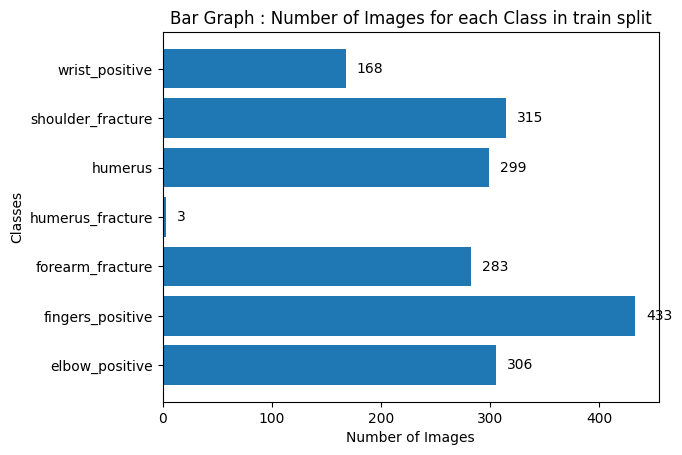

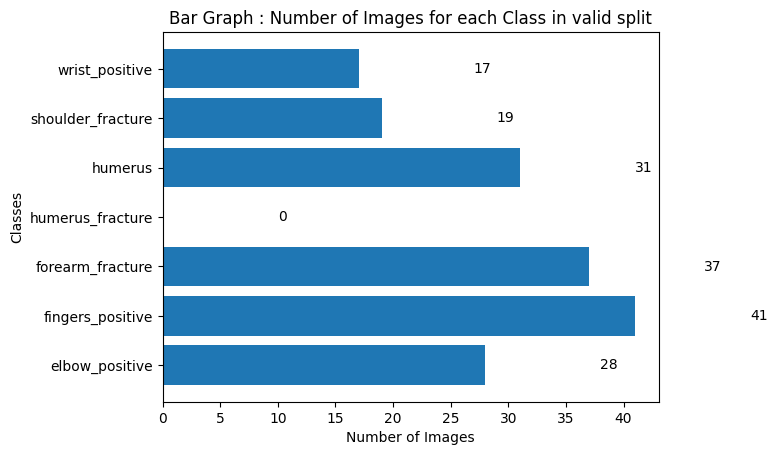

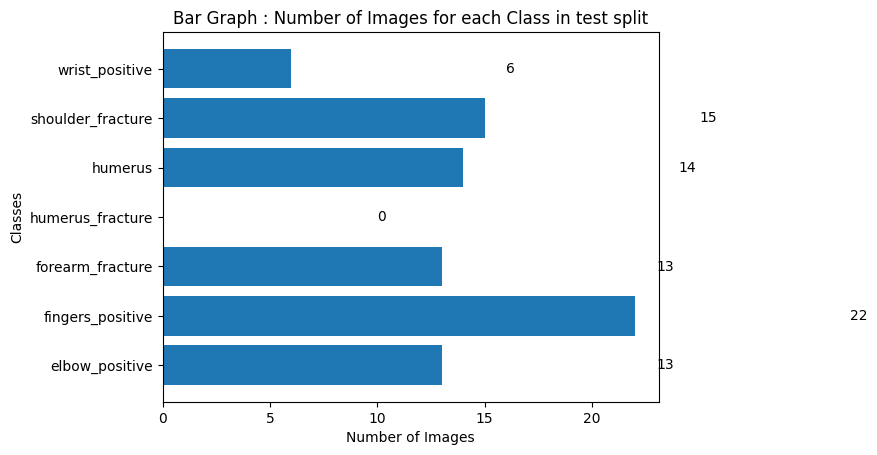

In [9]:
# Plot bar graph to see number of images for each class to check data imbalance
for split in splits:
    image_count = []

    for class_dir in class_directories:
        class_path = os.path.join(output_dir, split, class_dir)

        no_of_images = 0
        for image in os.listdir(class_path):
            if image.endswith(('.jpg', '.png')):
                no_of_images += 1
        image_count.append(no_of_images)

    # Create the bar graph
    bars = plt.barh(class_directories, image_count)

    # Add labels and title
    plt.xlabel('Number of Images')
    plt.ylabel('Classes')
    plt.title(f'Bar Graph : Number of Images for each Class in {split} split')

    # Add image_count value on each bar
    for bar in bars:
        width = bar.get_width()  # Get the width of the bar (number of images)
        plt.text(width + 10, bar.get_y() + bar.get_height() / 2, str(width), 
                 va='center', ha='left', fontsize=10)

    # Display the graph
    plt.show()


#Removing empty directories

In [10]:
import os
import shutil

# Path to the directory
dir_path = '/kaggle/working/sortedDB_original/train/humerus_fracture'

# Check if the directory exists and delete it regardless of whether it is empty or not
if os.path.exists(dir_path):
    shutil.rmtree(dir_path)  # Deletes the directory and all its contents
    print(f"Directory {dir_path} and all its contents have been deleted.")
else:
    print(f"Directory {dir_path} does not exist.")

# Deleting humerus fracture from test directory

# Path to the directory
dir_path = '/kaggle/working/sortedDB_original/valid/humerus_fracture'

# Check if the directory exists and is empty, then remove it
if os.path.exists(dir_path) and not os.listdir(dir_path):
    os.rmdir(dir_path)
    print(f"Directory {dir_path} deleted.")
else:
    print(f"Directory {dir_path} is not empty or does not exist.")


# Deleting humerus fracture from valid directory

# Path to the directory
dir_path = '/kaggle/working/sortedDB_original/test/humerus_fracture'

# Check if the directory exists and is empty, then remove it
if os.path.exists(dir_path) and not os.listdir(dir_path):
    os.rmdir(dir_path)
    print(f"Directory {dir_path} deleted.")
else:
    print(f"Directory {dir_path} is not empty or does not exist.")

Directory /kaggle/working/sortedDB_original/train/humerus_fracture and all its contents have been deleted.
Directory /kaggle/working/sortedDB_original/valid/humerus_fracture deleted.
Directory /kaggle/working/sortedDB_original/test/humerus_fracture deleted.


Resizing in sorted DB & 224*224 storing them in . 

In [11]:
class_directories = ['elbow_positive', 'fingers_positive', 'forearm_fracture',
                     'humerus', 'shoulder_fracture', 'wrist_positive']

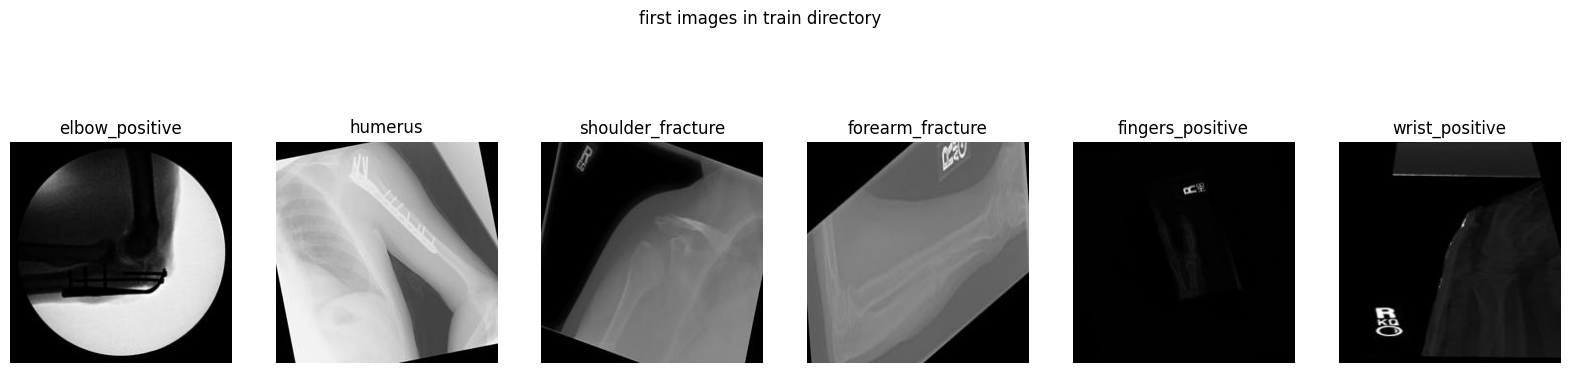

In [12]:
def resize224(image):
    return image.resize((224, 224))

create_dirs(splits, class_directories, "/kaggle/working/imageResize224*224")
move_images_sortedAfterOperation(output_dir, "/kaggle/working/imageResize224*224", resize224)
display_random_first_images_each_categories("/kaggle/working/imageResize224*224", split='train')

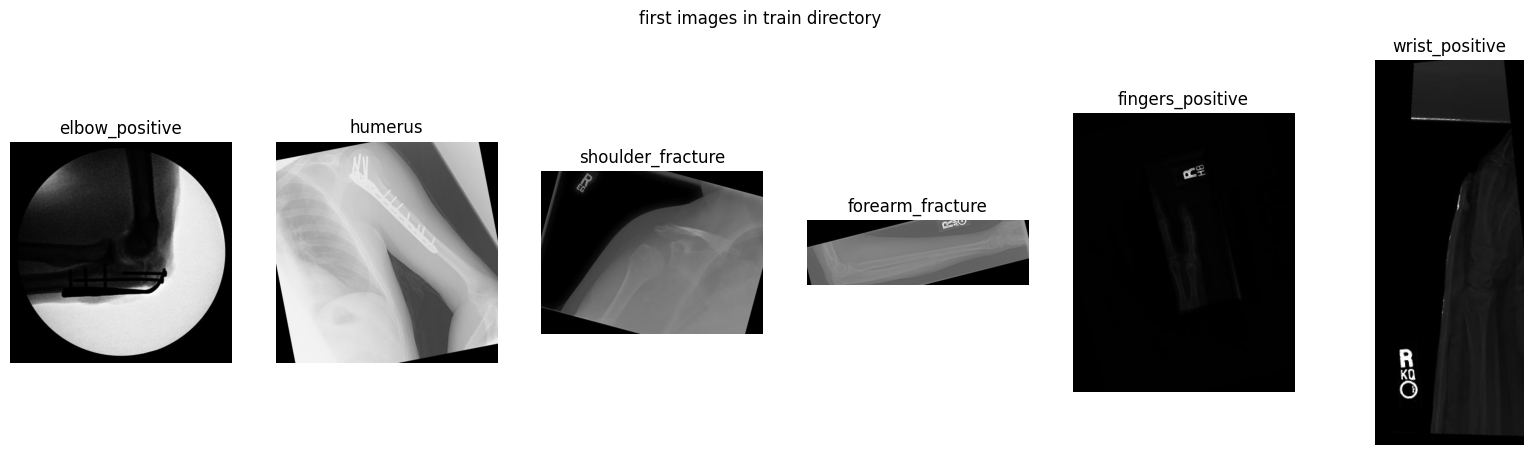

In [13]:
display_random_first_images_each_categories("/kaggle/working/sortedDB_original")

In [14]:
# 2. CLAHE (on grayscale)
def clahe_filter(image):
    image = image.convert('L')
    img_np = np.array(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(img_np)
    return Image.fromarray(enhanced).resize((224, 224))

# 3. Median Filter
def median_filter(image):
    image = image.convert('L')
    img_np = np.array(image)
    filtered = cv2.medianBlur(img_np, 3)
    return Image.fromarray(filtered).resize((224, 224))

# 4. Bilateral Filter
def bilateral_filter(image):
    image = image.convert('L')
    img_np = np.array(image)
    filtered = cv2.bilateralFilter(img_np, d=9, sigmaColor=75, sigmaSpace=75)
    return Image.fromarray(filtered).resize((224, 224))

# 5. CLAHE + Median Filter
def clahe_median_filter(image):
    image = image.convert('L')
    img_np = np.array(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(img_np)
    medianed = cv2.medianBlur(enhanced, 3)
    return Image.fromarray(medianed).resize((224, 224))

In [15]:
# CLAHE
create_dirs(splits, class_directories, "/kaggle/working/clahe_filtered")
move_images_sortedAfterOperation(output_dir, "/kaggle/working/clahe_filtered", clahe_filter)

# Median Filter
create_dirs(splits, class_directories, "/kaggle/working/median_filtered")
move_images_sortedAfterOperation(output_dir, "/kaggle/working/median_filtered", median_filter)

# Bilateral Filter
create_dirs(splits, class_directories, "/kaggle/working/bilateral_filtered")
move_images_sortedAfterOperation(output_dir, "/kaggle/working/bilateral_filtered", bilateral_filter)

# CLAHE + Median Filter (Bonus)
create_dirs(splits, class_directories, "/kaggle/working/clahe_median_filtered")
move_images_sortedAfterOperation(output_dir, "/kaggle/working/clahe_median_filtered", clahe_median_filter)


PSNR: It quantifies how much noise or distortion has been introduced.

PSNR Value (in dB)	Interpretation
> 40 dB	Excellent quality (almost identical)
30–40 dB	Good quality
20–30 dB	Acceptable / Noticeable distortion
< 20 dB	Poor quality / Significant loss

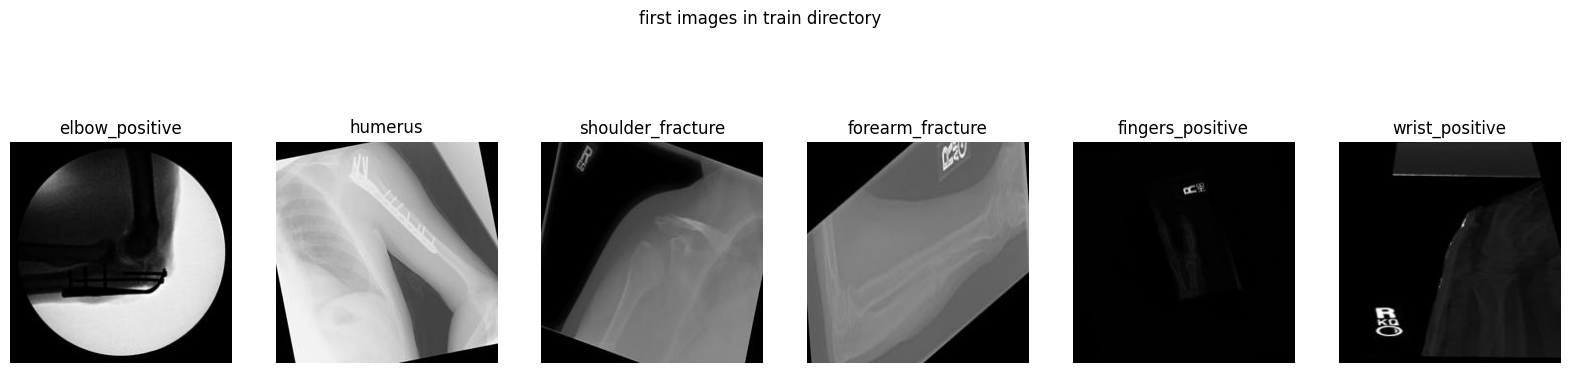

In [16]:
display_random_first_images_each_categories("/kaggle/working/imageResize224*224", split='train')

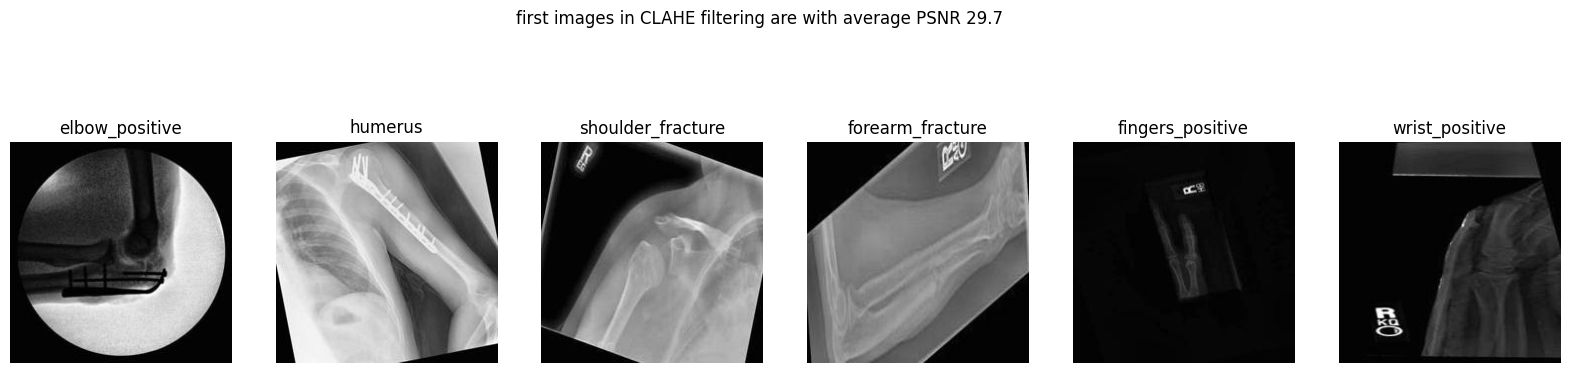

In [17]:
#CLAHE
PSNR_clahe = compare_original_and_processed_images(processed_dir = "/kaggle/working/clahe_filtered" , operation = psnr)
display_random_first_images_each_categories("/kaggle/working/clahe_filtered", split='train', titleForPSNR = 'CLAHE', PSNR = PSNR_clahe)

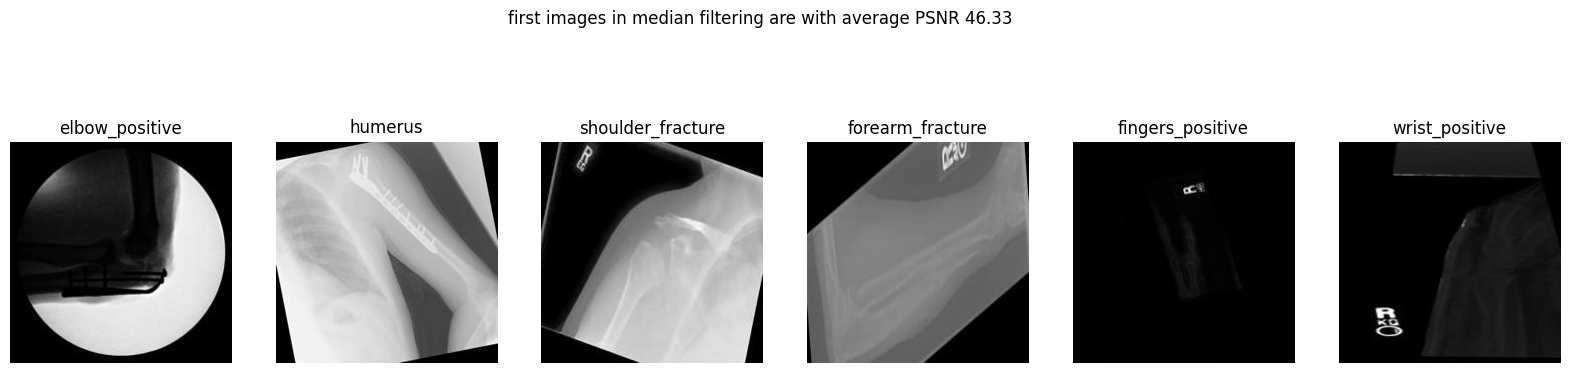

In [18]:
#Median
PSNR_Median = compare_original_and_processed_images(processed_dir = "/kaggle/working/median_filtered", operation = psnr)
display_random_first_images_each_categories("/kaggle/working/median_filtered", split='train', titleForPSNR = 'median', PSNR = PSNR_Median)

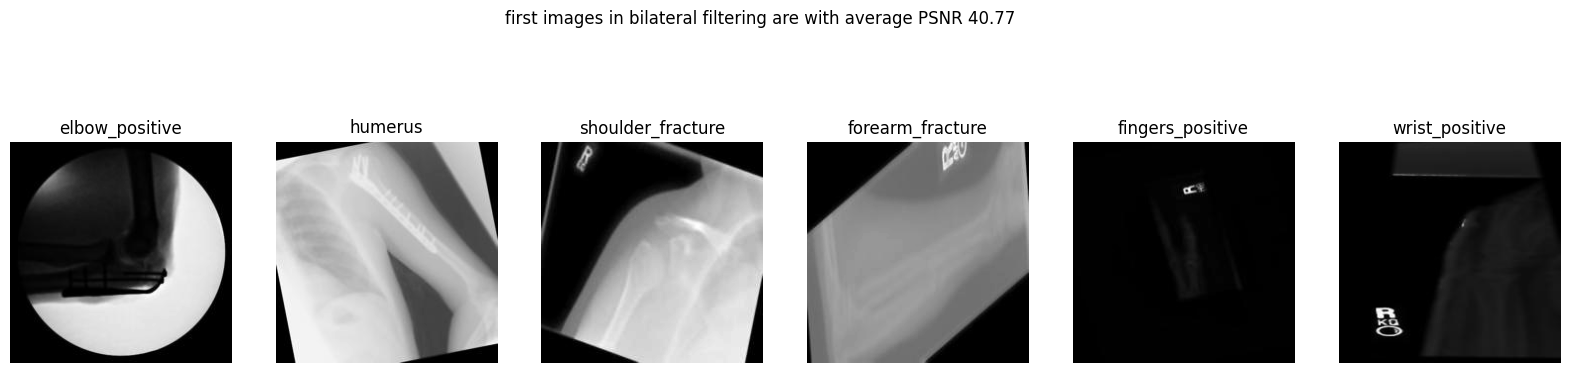

In [19]:
PSNR_bilateral = compare_original_and_processed_images(processed_dir = "/kaggle/working/bilateral_filtered", operation = psnr)
display_random_first_images_each_categories("/kaggle/working/bilateral_filtered", split='train', titleForPSNR = 'bilateral', PSNR = PSNR_bilateral)

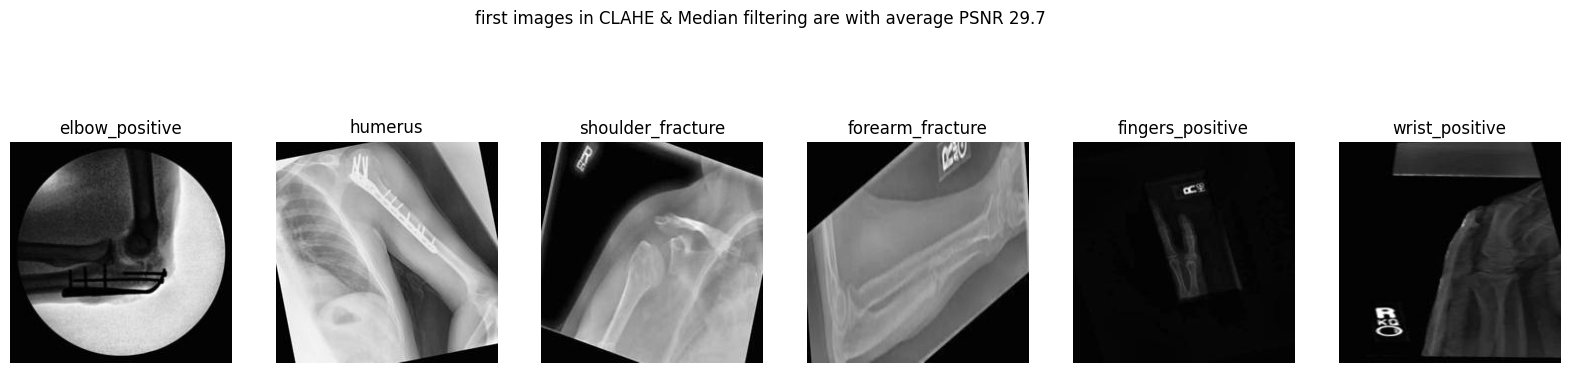

In [20]:
PSNR_clahe_median = compare_original_and_processed_images(processed_dir = "/kaggle/working/clahe_median_filtered", operation = psnr)
display_random_first_images_each_categories("/kaggle/working/clahe_median_filtered", split='train', titleForPSNR = 'CLAHE & Median', PSNR = PSNR_clahe_median)

### Preprocessing: Normalization & Scaling

In [21]:
# Mean and standard deviation for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        #transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        #transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}


### Load the dataset

In [22]:
# Load the datasets
train_dataset = datasets.ImageFolder('/kaggle/working/imageResize224*224', transform=data_transforms['train'])
valid_dataset = datasets.ImageFolder('/kaggle/working/imageResize224*224', transform=data_transforms['valid'])
test_dataset = datasets.ImageFolder('/kaggle/working/imageResize224*224', transform=data_transforms['test'])


In [23]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [25]:
#EPOCHS = 15
DROPOUT_PROB = 0.3
WEIGHT_DECAY = 0.01
LEARNING_RATE = 0.01
SCHEDULER_STEP_SIZE = 5
GAMMA = 0.01

## Define and Create CNN Model

In [26]:
num_classes = len(train_dataset.classes)

# Define CNN Architecture
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()

    # Define and initialize Convolutional layers
    self.conv_layer_1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv_layer_2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv_layer_3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.conv_layer_4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

    # Batch Normalization
    self.batch_norm_1 = nn.BatchNorm2d(32)
    self.batch_norm_2 = nn.BatchNorm2d(64)
    self.batch_norm_3 = nn.BatchNorm2d(128)
    self.batch_norm_4 = nn.BatchNorm2d(256)

    # Dropout regularization with probability of DROPOUT_PROB
    self.dropout = nn.Dropout(DROPOUT_PROB)

    # Define Max Pooling layer
    self.max_pool = nn.MaxPool2d(2, 2)

    # Activation function
    self.activation_function = nn.ReLU()

    # Define and initialize Linear layers
    self.linear_layer_1 = nn.Linear(256 * 14 * 14, 1024)
    # self.linear_layer_2 = nn.Linear(512, 1024)
    self.linear_layer_output = nn.Linear(1024, num_classes)

    # Apply Kaiming initialization
    self.initialize_weights()

  def initialize_weights(self):
    # Apply Xavier initialization to convolutional layers
    init.kaiming_uniform_(self.conv_layer_1.weight, mode='fan_out', nonlinearity='relu')
    init.kaiming_uniform_(self.conv_layer_2.weight, mode='fan_out', nonlinearity='relu')
    init.kaiming_uniform_(self.conv_layer_3.weight, mode='fan_out', nonlinearity='relu')
    init.kaiming_uniform_(self.conv_layer_4.weight, mode='fan_out', nonlinearity='relu')

    # Apply Xavier initialization to fully connected layers
    init.kaiming_uniform_(self.linear_layer_1.weight, mode='fan_out', nonlinearity='relu')
    # init.kaiming_uniform_(self.linear_layer_2.weight, mode='fan_out', nonlinearity='relu')
    init.kaiming_uniform_(self.linear_layer_output.weight, mode='fan_out', nonlinearity='relu')

    # Initialize all biases to zeros
    if self.conv_layer_1.bias is not None:
      init.zeros_(self.conv_layer_1.bias)
    if self.conv_layer_2.bias is not None:
      init.zeros_(self.conv_layer_2.bias)
    if self.conv_layer_3.bias is not None:
      init.zeros_(self.conv_layer_3.bias)
    if self.conv_layer_4.bias is not None:
      init.zeros_(self.conv_layer_4.bias)

    if self.linear_layer_1.bias is not None:
      init.zeros_(self.linear_layer_1.bias)
    # if self.linear_layer_2.bias is not None:
    #   init.zeros_(self.linear_layer_2.bias)
    if self.linear_layer_output.bias is not None:
      init.zeros_(self.linear_layer_output.bias)


  def forward(self, x):
    x = self.max_pool(self.activation_function(self.batch_norm_1(self.conv_layer_1(x))))
    x = self.max_pool(self.dropout(self.activation_function(self.batch_norm_2(self.conv_layer_2(x)))))
    x = self.max_pool(self.activation_function(self.batch_norm_3(self.conv_layer_3(x))))
    x = self.max_pool(self.dropout(self.activation_function(self.batch_norm_4(self.conv_layer_4(x)))))

    x = x.view(-1, 256 * 14 * 14)

    x = self.dropout(self.activation_function(self.linear_layer_1(x)))
    # x = self.dropout(self.activation_function(self.linear_layer_2(x)))
    x = self.linear_layer_output(x)

    return x


# Instantiate CNN model
cnn_model = CNNModel()
cnn_model = cnn_model.to(device)
print(cnn_model)

CNNModel(
  (conv_layer_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (activation_function): ReLU()
  (linear_layer_1): Linear(in_features=50176, out_features=1024, bias=True)
  (linear_layer_ou

## Load & Modify ResNet Model

## Model Training

## Evaluation

In [27]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
# Mean and standard deviation for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        #transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        #transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}


In [35]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=20):
    train_acc = []
    val_acc = []
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)  # accumulate total loss
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        train_losses.append(epoch_loss)
        train_acc.append(100 * correct / total)

        # Validation
        model.eval()
        correct = 0
        total = 0
        val_running_loss = 0.0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_epoch_loss = val_running_loss / total
        val_losses.append(val_epoch_loss)
        val_acc.append(100 * correct / total)

    return train_acc, val_acc, train_losses, val_losses


# Training Function
def train_model_CNN(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=20):
  best_acc = 0.0
  # print(device)

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs} : ', end='')

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      # Zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)

      # Backward pass and optimization
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

    #scheduler.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * running_corrects.double() / len(train_loader.dataset)

    print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} %;   ', end='')

    # Store average loss and accuracy for the epoch to plot graph
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())  # ✅ Fix

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0

    with torch.no_grad():
      for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

        val_running_loss += loss.item() * inputs.size(0)
        val_running_corrects += torch.sum(preds == labels.data)

    val_loss = val_running_loss / len(valid_loader.dataset)
    val_acc = 100 * val_running_corrects.double() / len(valid_loader.dataset)

    print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f} %')

    # Store average loss and accuracy for the epoch to plot graph
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())  # ✅ Fix

    # Save the best model
    if isinstance(model, CNNModel):
      best_model_path = 'best_cnn_model.pth'
    else:
      best_model_path = 'best_resnet_model.pth'

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), best_model_path)

  print(f'Best Validation Accuracy: {best_acc:.4f}')

  return train_accuracies, val_accuracies, train_losses, val_losses


In [30]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    return accuracy, precision, recall, f1, y_true, y_pred


In [31]:
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


In [36]:
import torch
import torchvision.models as models
from torchvision.models import (
    vgg16,
    resnet18,
    densenet121,
    efficientnet_b0
)


# Load pretrained models
model_vgg16 = vgg16(pretrained=True)
model_resnet18 = resnet18(pretrained=True)
model_densenet121 = densenet121(pretrained=True)
model_efficientnet_b0 = efficientnet_b0(pretrained=True)

num_classes = 6  # change based on your dataset

# Modify VGG16
model_vgg16.classifier[6] = torch.nn.Linear(model_vgg16.classifier[6].in_features, num_classes)

# Modify ResNet-18
model_resnet18.fc = torch.nn.Linear(model_resnet18.fc.in_features, num_classes)

# Modify DenseNet121
model_densenet121.classifier = torch.nn.Linear(model_densenet121.classifier.in_features, num_classes)

# Modify EfficientNet-B0
model_efficientnet_b0.classifier[1] = torch.nn.Linear(model_efficientnet_b0.classifier[1].in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device, "is the device")

model_vgg16 = model_vgg16.to(device)
model_resnet18 = model_resnet18.to(device)
model_densenet121 = model_densenet121.to(device)
model_efficientnet_b0 = model_efficientnet_b0.to(device)
CNN_model = CNNModel()

pretrained_models = [CNN_model, model_vgg16, model_resnet18, model_densenet121, model_efficientnet_b0]

cuda is the device


 Processing Filtered Dataset: clahe_median_filtered
✅ Training model: CNNModel on clahe_median_filtered
Epoch 1/20 : Train Loss: 244.8006, Train Acc: 15.9091 %;   Validation Loss: 112.7503, Validation Acc: 16.7630 %
Epoch 2/20 : Train Loss: 249.6922, Train Acc: 13.5809 %;   Validation Loss: 120.4056, Validation Acc: 16.7630 %
Epoch 3/20 : Train Loss: 249.9791, Train Acc: 13.8581 %;   Validation Loss: 118.1367, Validation Acc: 16.7630 %
Epoch 4/20 : Train Loss: 248.5341, Train Acc: 14.4124 %;   Validation Loss: 117.9618, Validation Acc: 16.7630 %
Epoch 5/20 : Train Loss: 247.9783, Train Acc: 14.4678 %;   Validation Loss: 119.0253, Validation Acc: 17.3410 %
Epoch 6/20 : Train Loss: 245.2717, Train Acc: 14.9667 %;   Validation Loss: 120.0716, Validation Acc: 16.7630 %
Epoch 7/20 : Train Loss: 240.6638, Train Acc: 16.5743 %;   Validation Loss: 118.9117, Validation Acc: 16.7630 %
Epoch 8/20 : Train Loss: 249.1598, Train Acc: 14.3016 %;   Validation Loss: 117.1254, Validation Acc: 17.3410 %


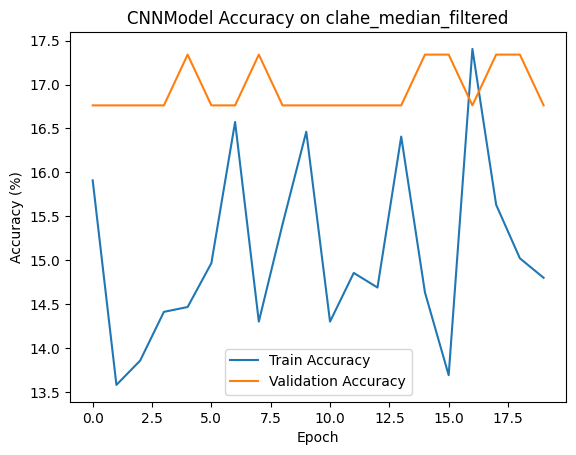

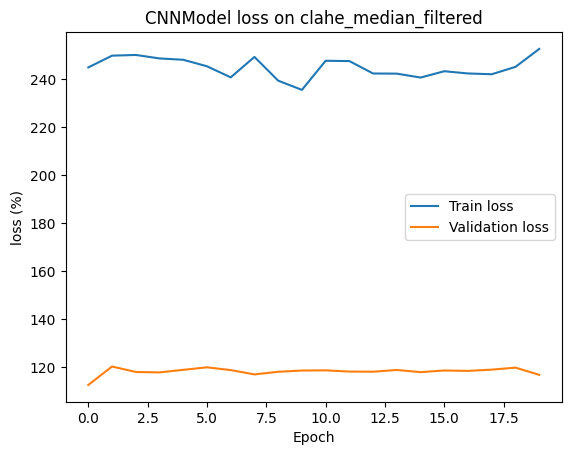

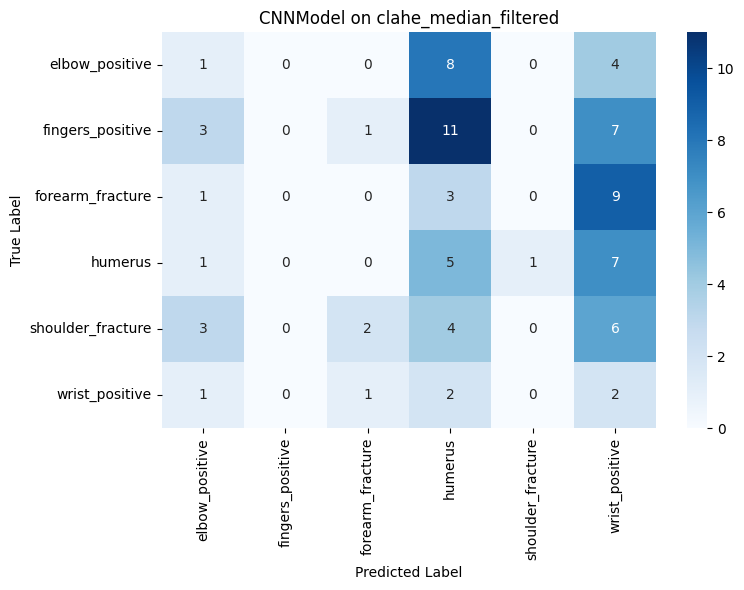

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
✅ Training model: VGG on clahe_median_filtered


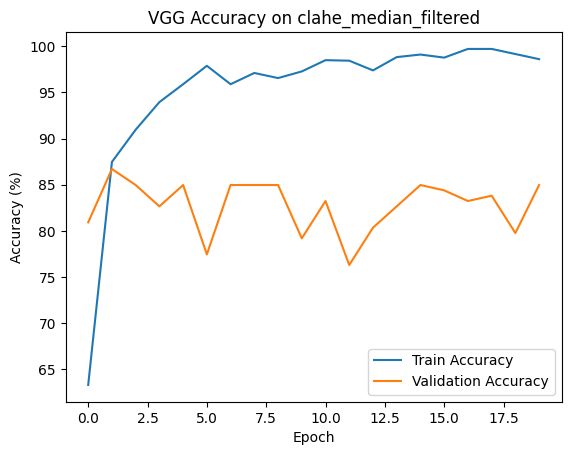

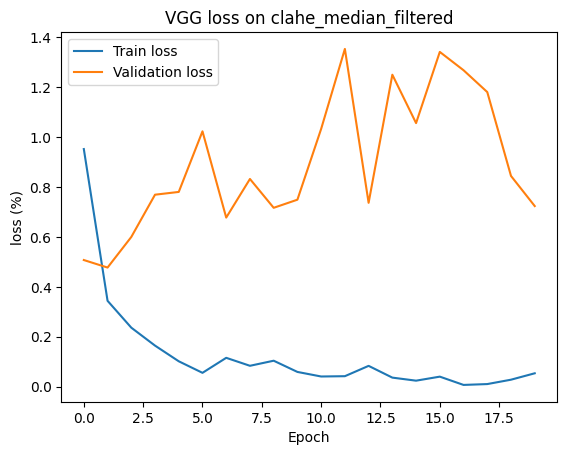

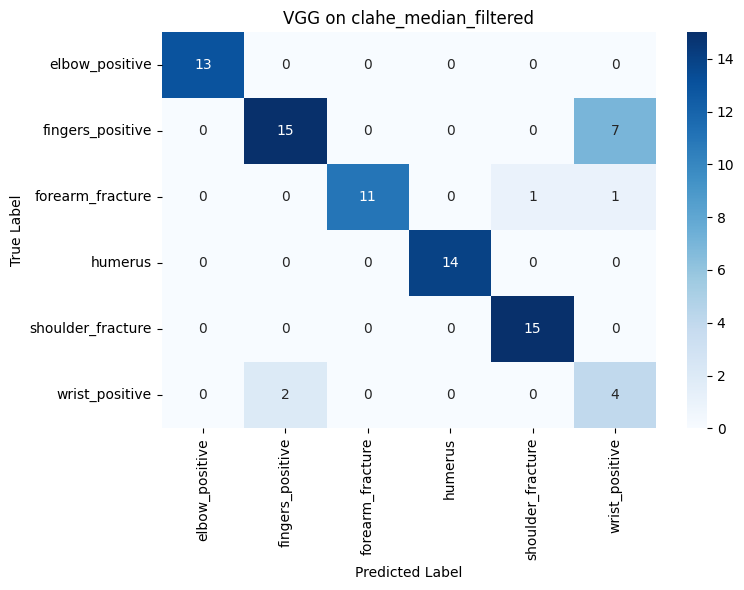

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
✅ Training model: ResNet on clahe_median_filtered


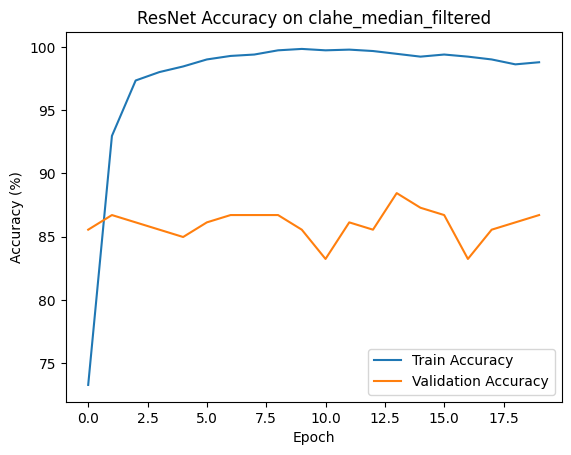

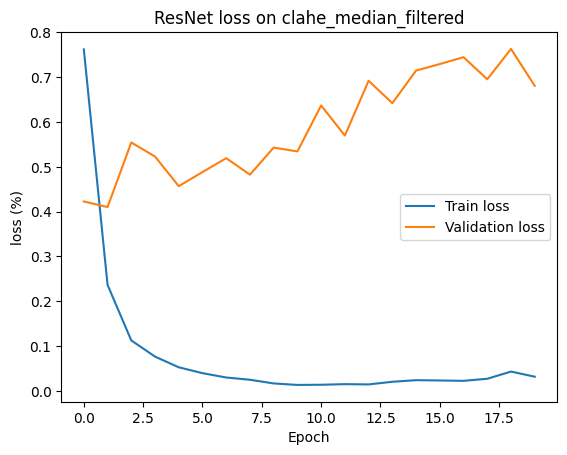

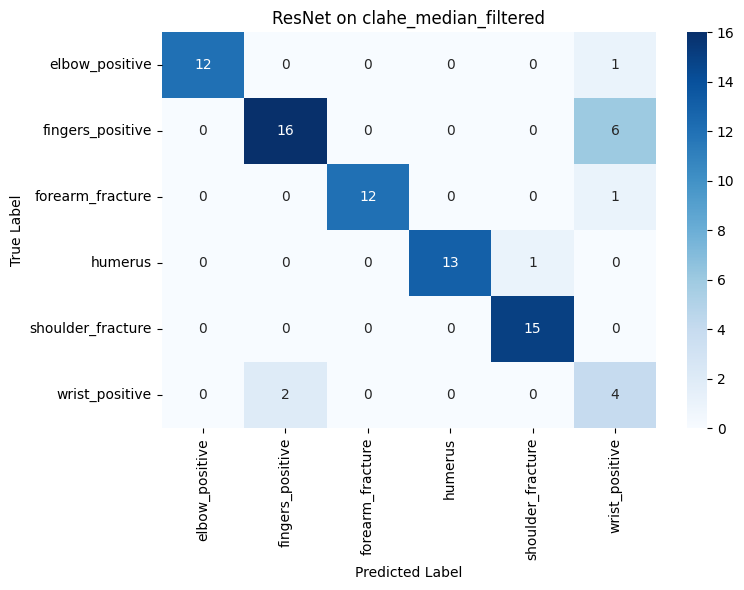

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
✅ Training model: DenseNet on clahe_median_filtered


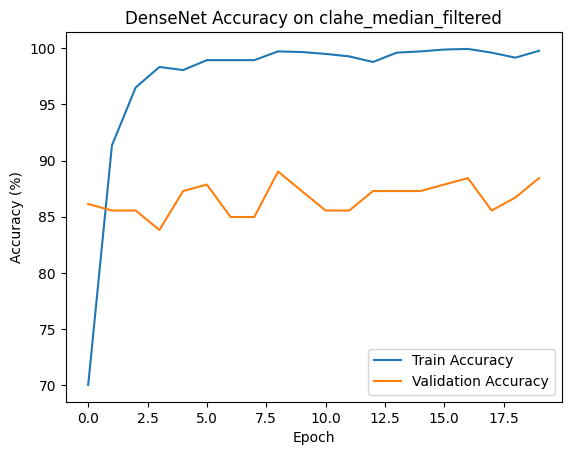

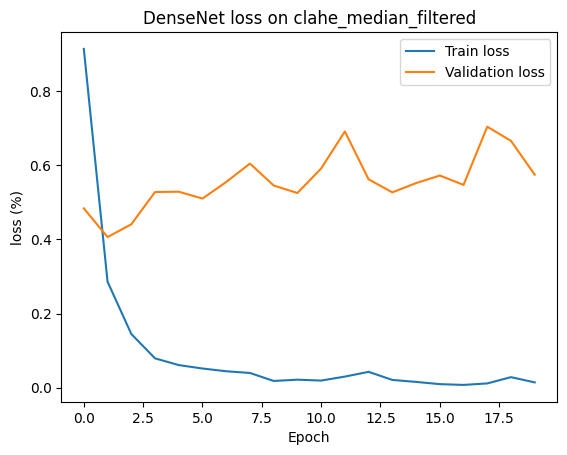

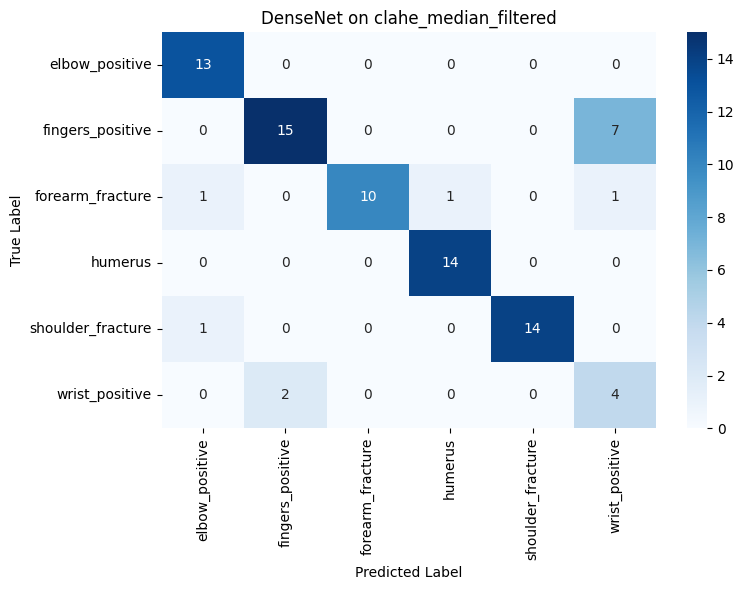

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
✅ Training model: EfficientNet on clahe_median_filtered


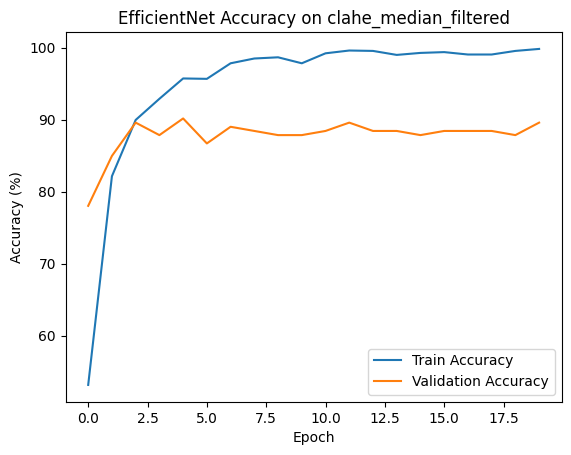

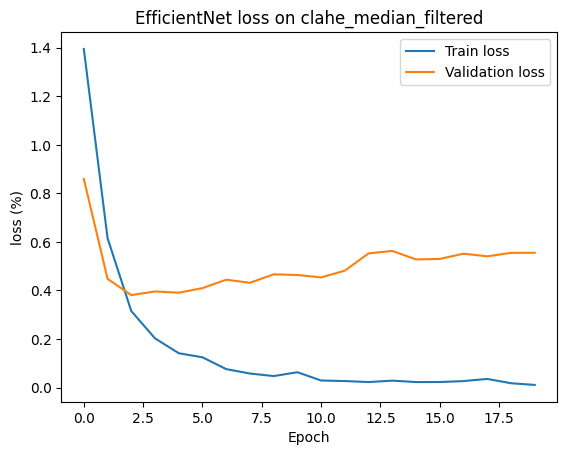

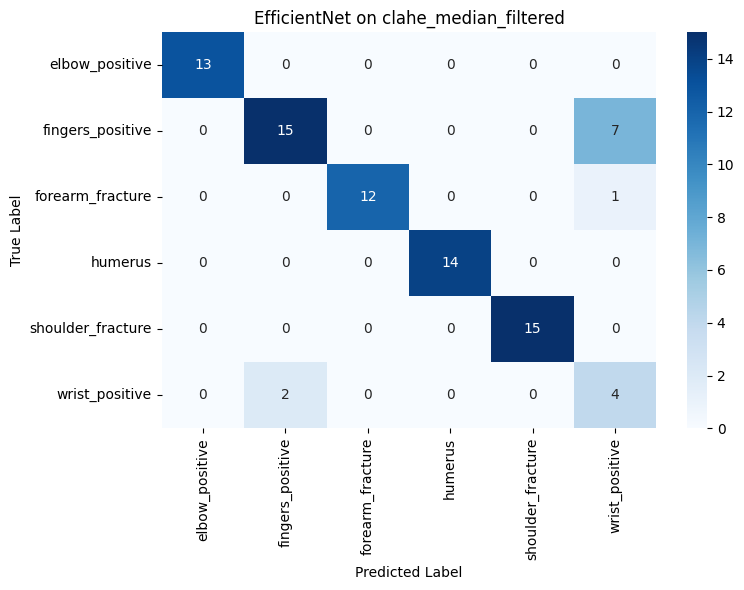

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
 Processing Filtered Dataset: median_filtered
✅ Training model: CNNModel on median_filtered
Epoch 1/20 : Train Loss: 236.3891, Train Acc: 15.6874 %;   Validation Loss: 119.5838, Validation Acc: 14.4509 %
Epoch 2/20 : Train Loss: 232.0272, Train Acc: 15.9645 %;   Validation Loss: 120.6575, Validation Acc: 13.2948 %
Epoch 3/20 : Train Loss: 234.0601, Train Acc: 16.9623 %;   Validation Loss: 119.9167, Validation Acc: 13.8728 %
Epoch 4/20 : Train Loss: 238.5942, Train Acc: 16.8514 %;   Validation Loss: 117.8723, Validation Acc: 15.0289 %
Epoch 5/20 : Train Loss: 240.8203, Train Acc: 14.9667 %;   Validation Loss: 120.9196, Validation Acc: 14.4509 %
Epoch 6/20 : Train Loss: 238.2915, Train Acc:

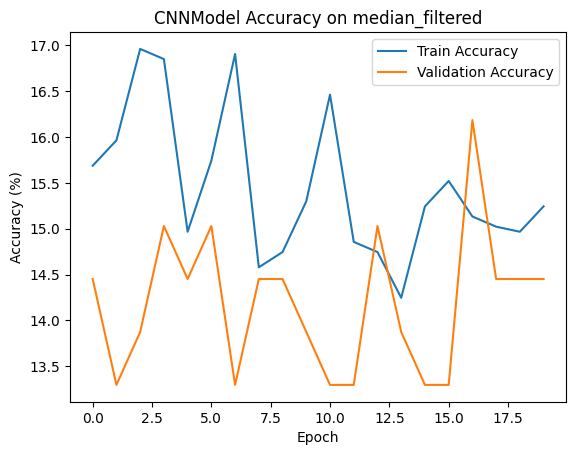

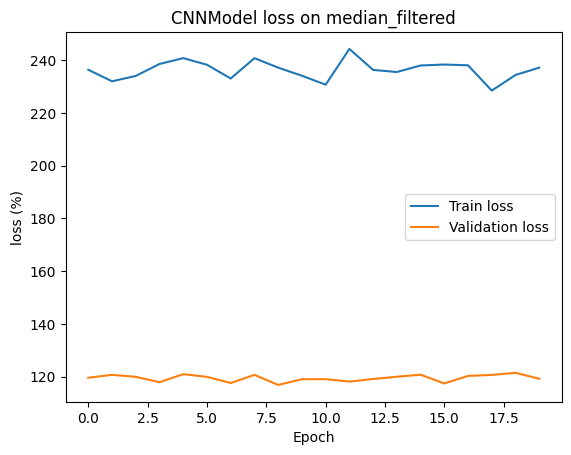

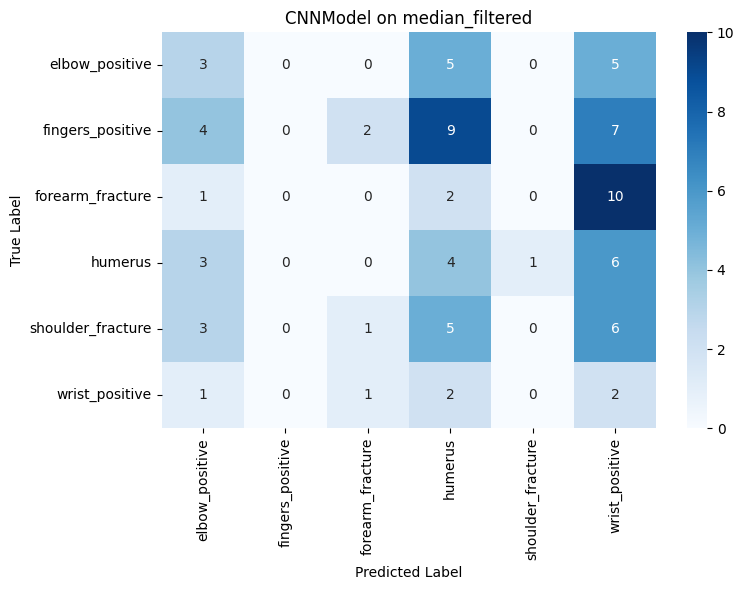

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
✅ Training model: VGG on median_filtered


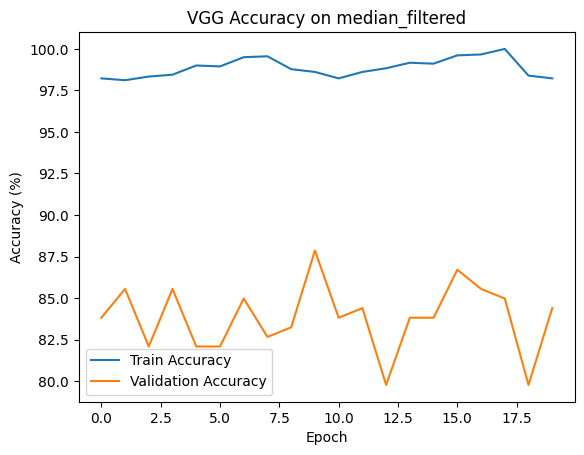

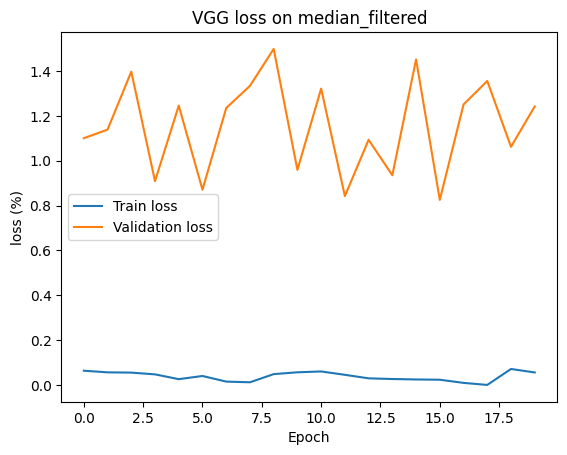

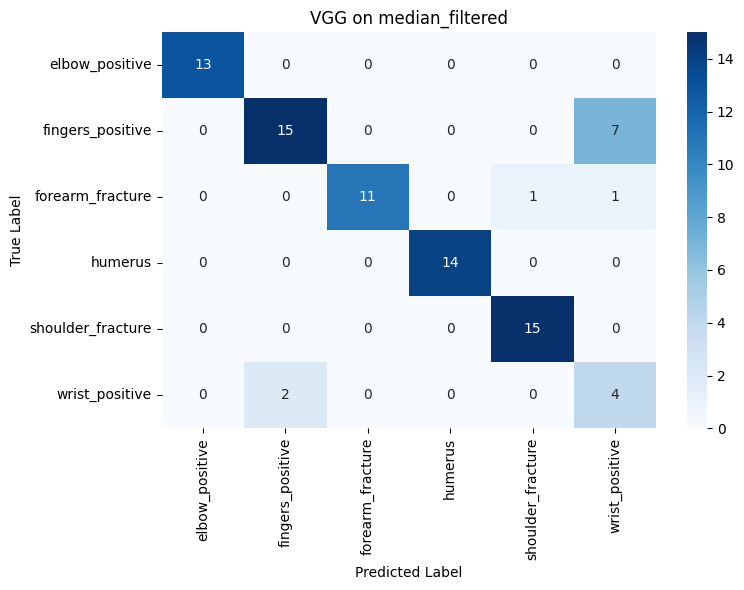

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
✅ Training model: ResNet on median_filtered


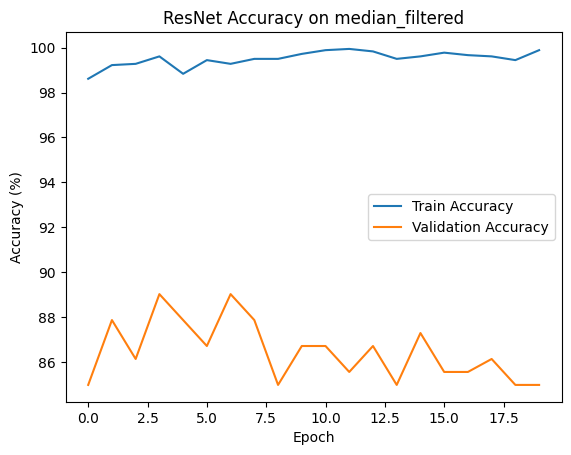

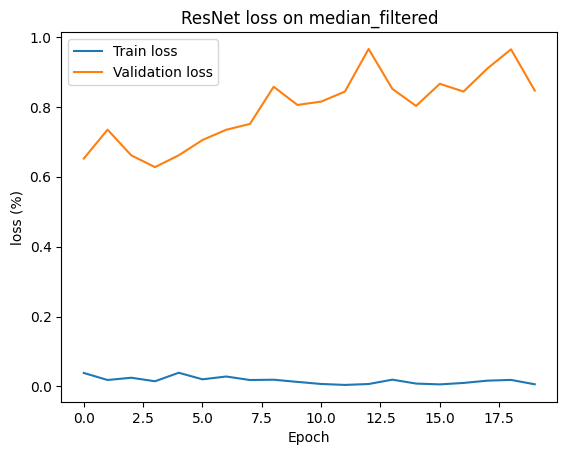

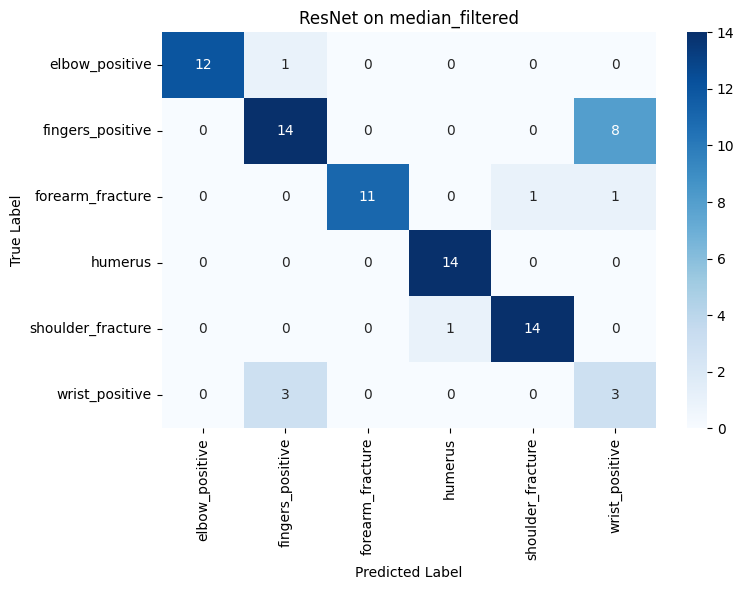

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
✅ Training model: DenseNet on median_filtered


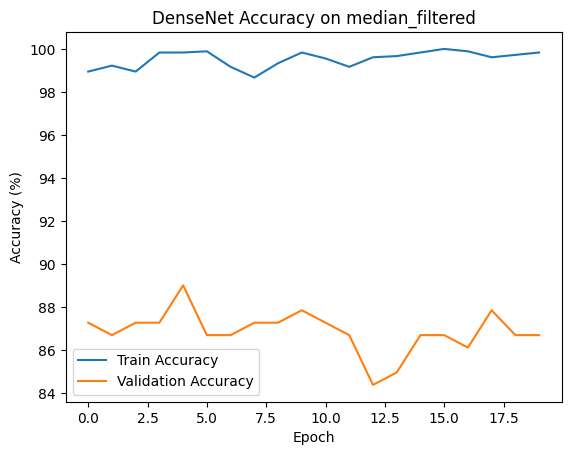

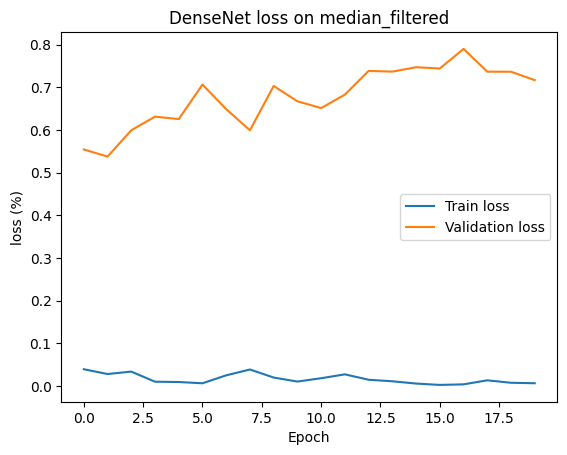

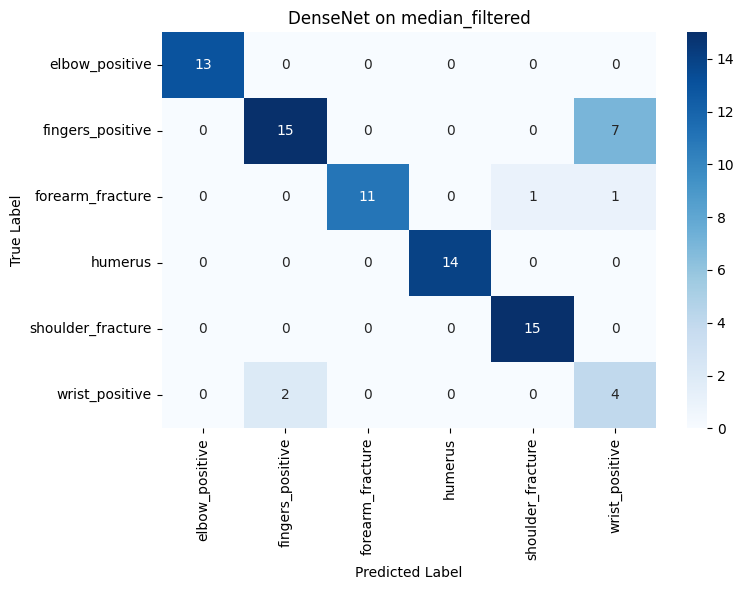

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
✅ Training model: EfficientNet on median_filtered


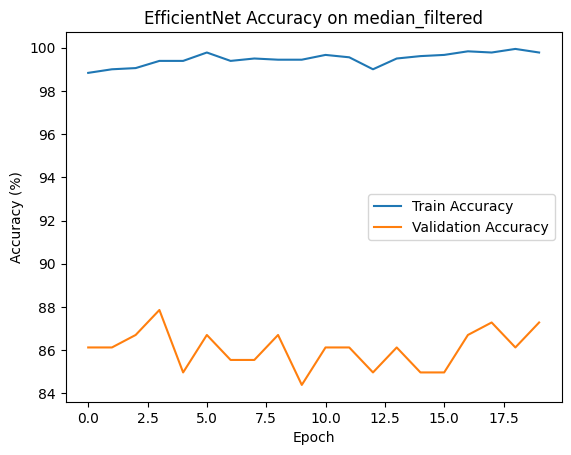

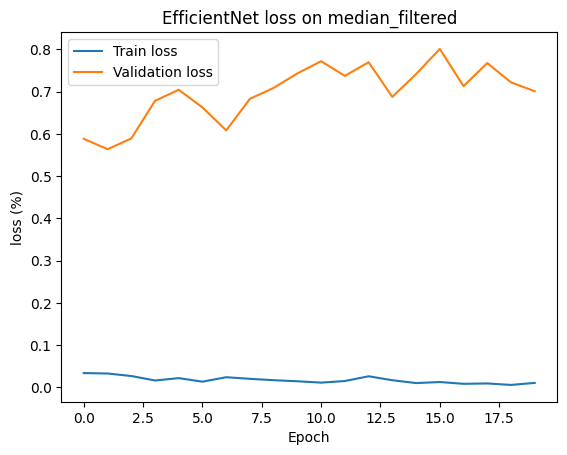

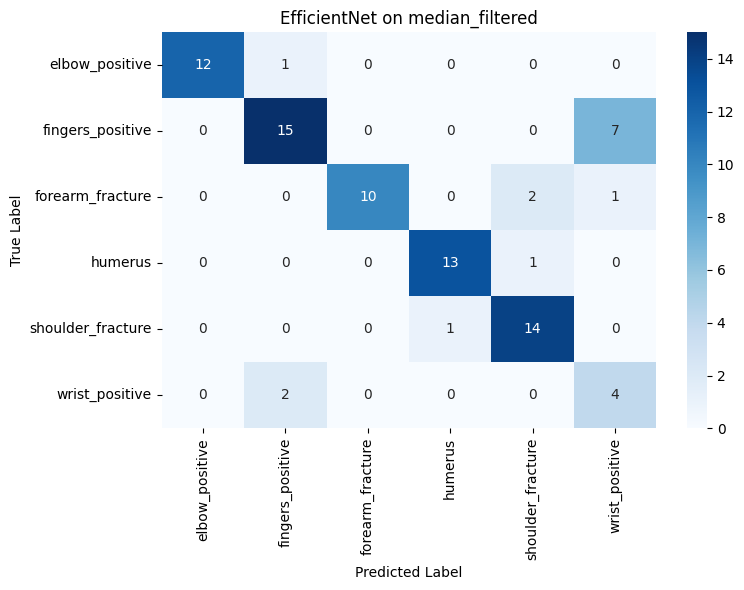

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
 Processing Filtered Dataset: imageResize224*224
✅ Training model: CNNModel on imageResize224*224
Epoch 1/20 : Train Loss: 243.0460, Train Acc: 15.5765 %;   Validation Loss: 122.7528, Validation Acc: 12.7168 %
Epoch 2/20 : Train Loss: 237.8362, Train Acc: 15.1885 %;   Validation Loss: 121.9219, Validation Acc: 12.7168 %
Epoch 3/20 : Train Loss: 235.2011, Train Acc: 16.4634 %;   Validation Loss: 119.1314, Validation Acc: 12.1387 %
Epoch 4/20 : Train Loss: 239.1983, Train Acc: 15.1330 %;   Validation Loss: 121.7851, Validation Acc: 13.2948 %
Epoch 5/20 : Train Loss: 242.1202, Train Acc: 14.8559 %;   Validation Loss: 123.2306, Validation Acc: 12.7168 %
Epoch 6/20 : Train Loss: 241.5184, Trai

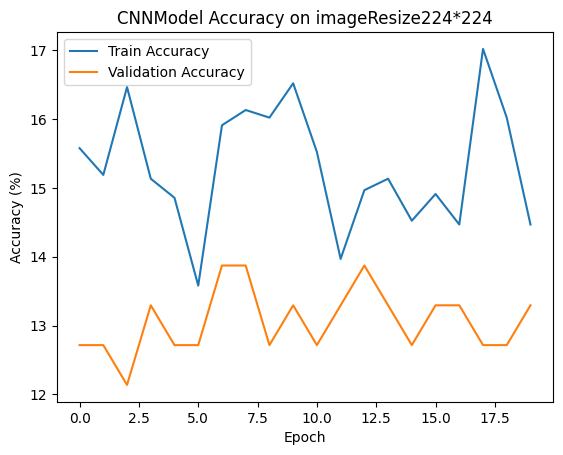

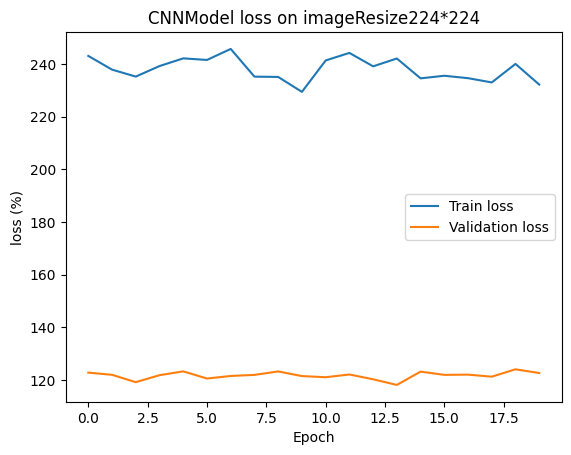

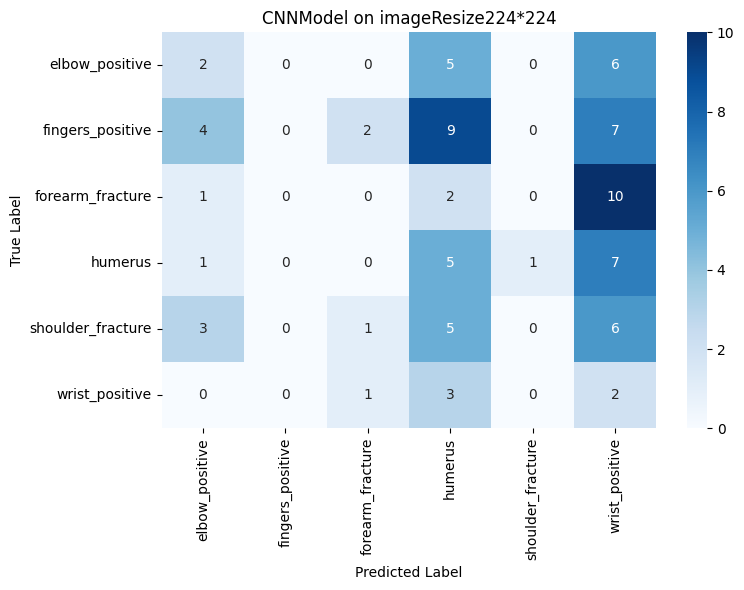

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
✅ Training model: VGG on imageResize224*224


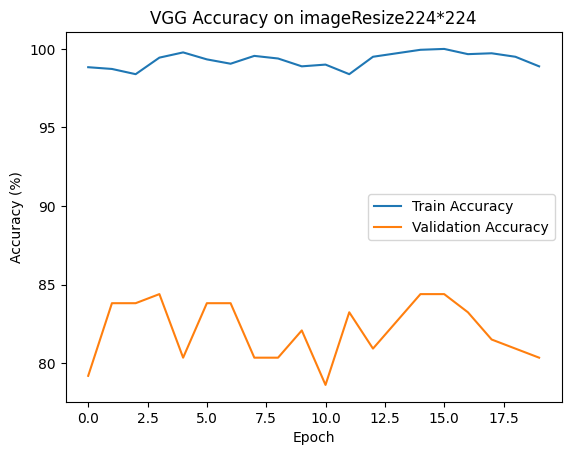

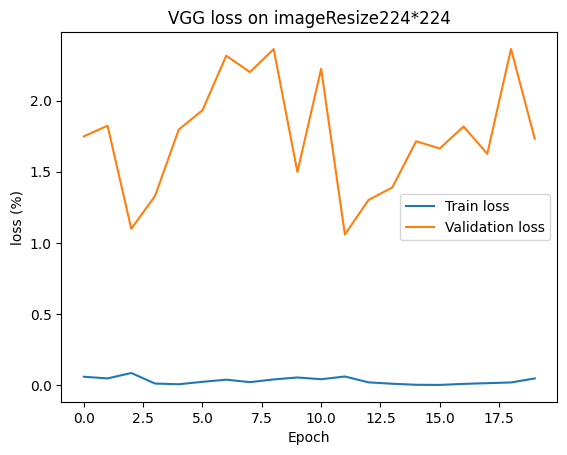

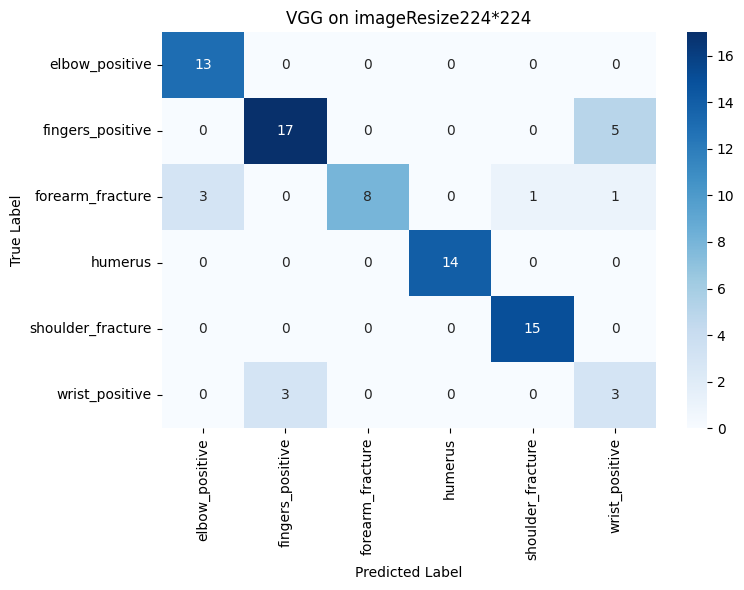

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
✅ Training model: ResNet on imageResize224*224


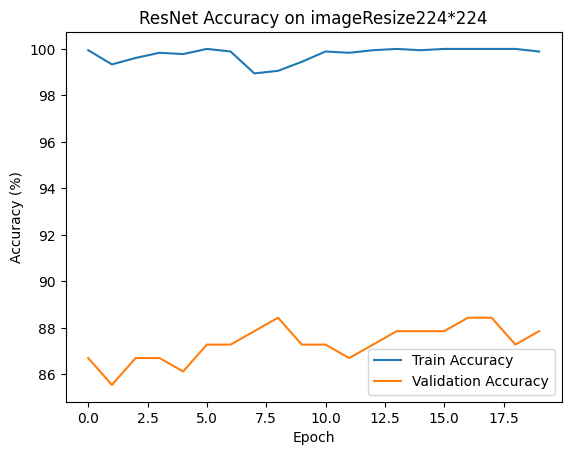

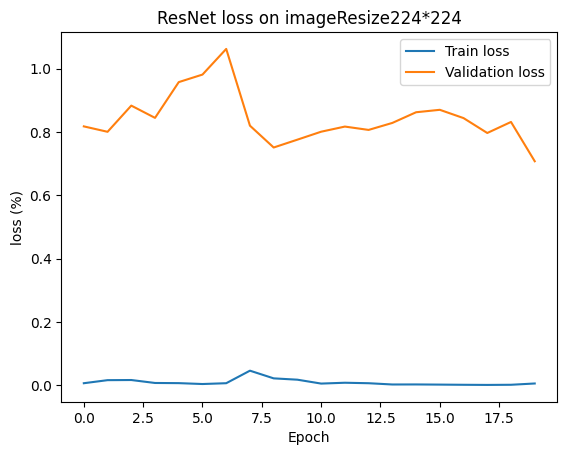

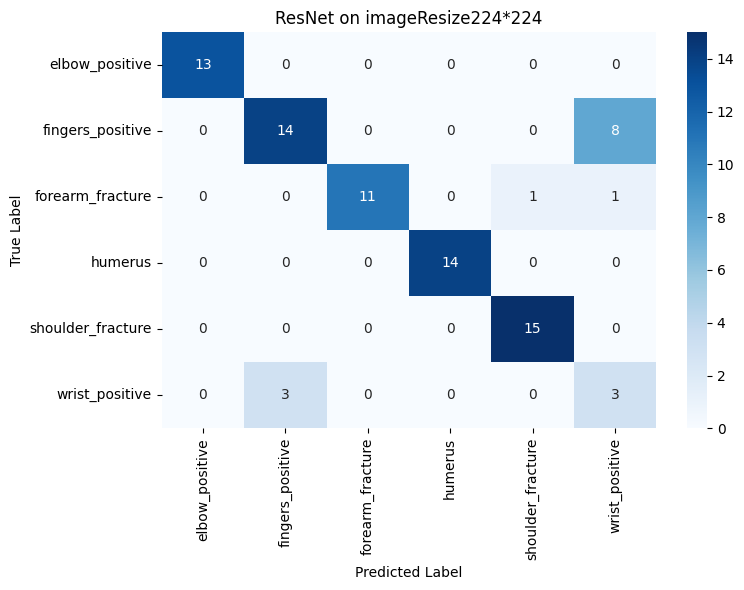

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
✅ Training model: DenseNet on imageResize224*224


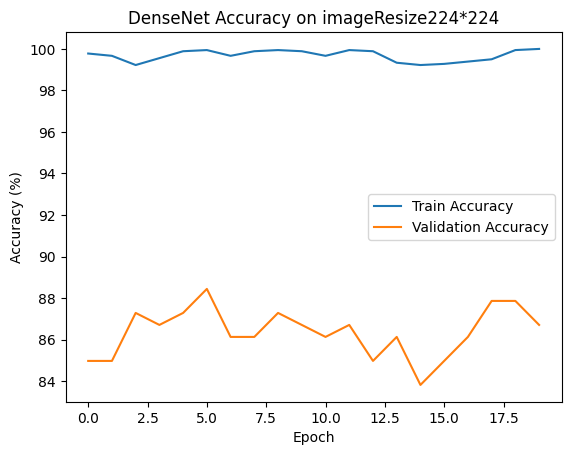

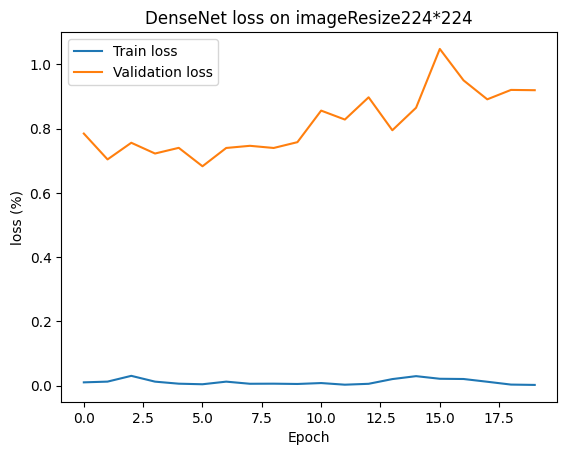

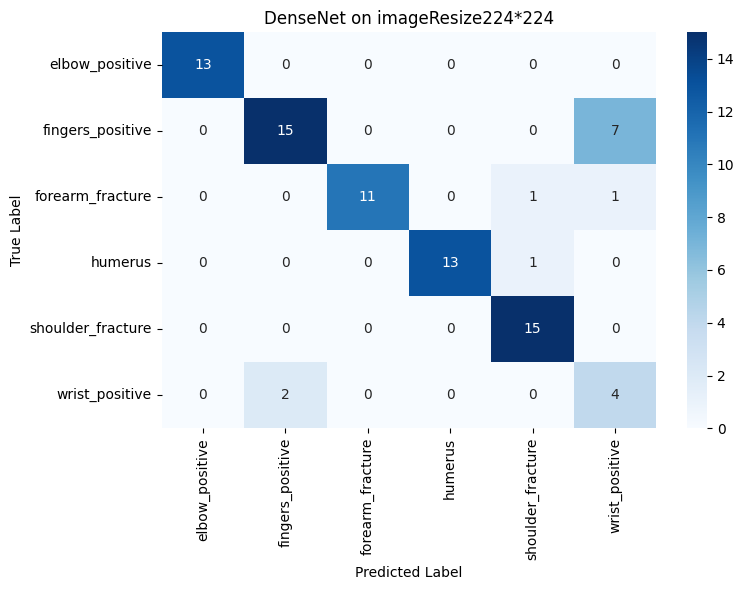

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
✅ Training model: EfficientNet on imageResize224*224


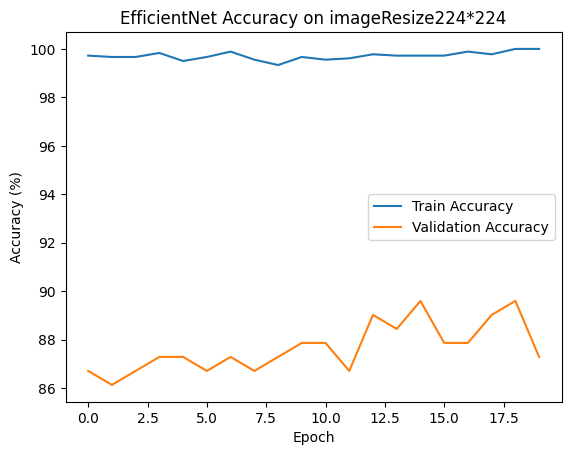

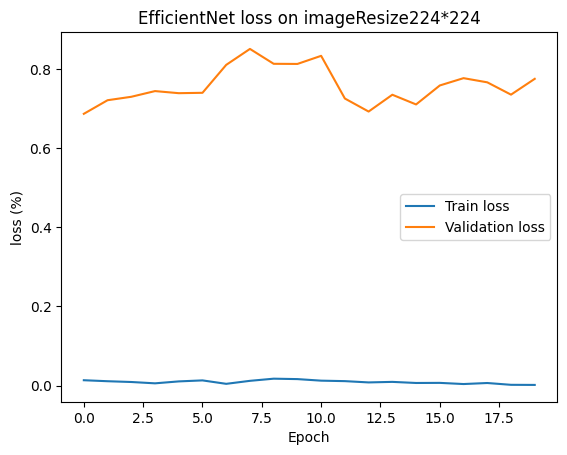

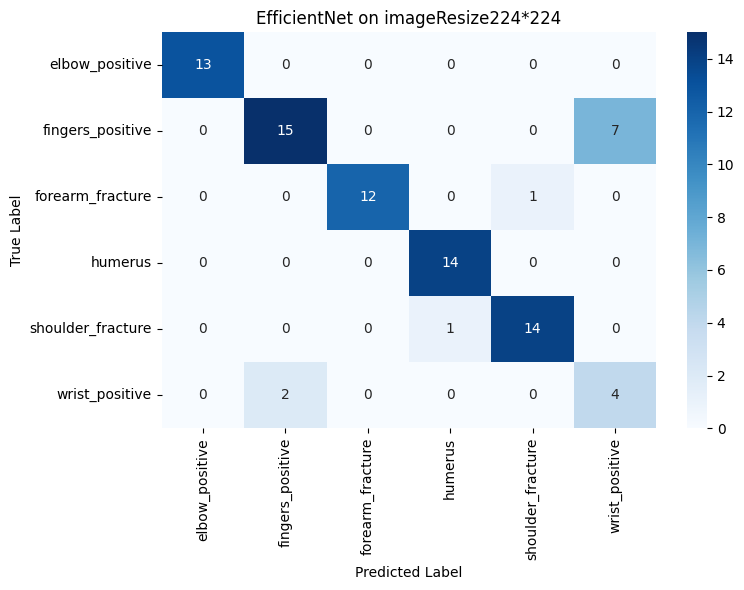

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
 Processing Filtered Dataset: clahe_filtered
✅ Training model: CNNModel on clahe_filtered
Epoch 1/20 : Train Loss: 242.8949, Train Acc: 16.1863 %;   Validation Loss: 119.5806, Validation Acc: 17.3410 %
Epoch 2/20 : Train Loss: 242.3484, Train Acc: 15.4656 %;   Validation Loss: 118.4837, Validation Acc: 17.9191 %
Epoch 3/20 : Train Loss: 251.6928, Train Acc: 14.6341 %;   Validation Loss: 119.7991, Validation Acc: 17.9191 %
Epoch 4/20 : Train Loss: 245.5740, Train Acc: 14.1353 %;   Validation Loss: 118.1860, Validation Acc: 18.4971 %
Epoch 5/20 : Train Loss: 250.9942, Train Acc: 15.4656 %;   Validation Loss: 118.5695, Validation Acc: 17.9191 %
Epoch 6/20 : Train Loss: 240.7419, Train Acc: 1

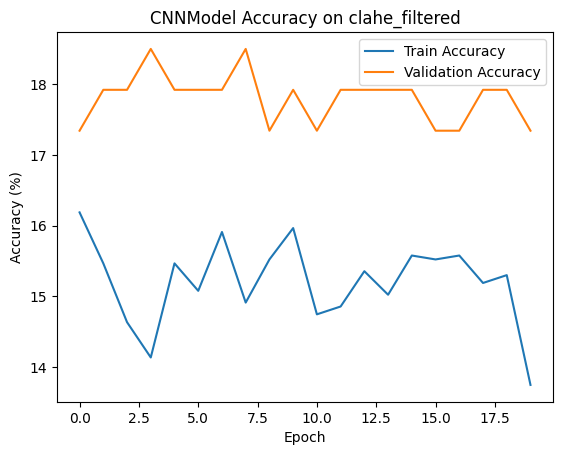

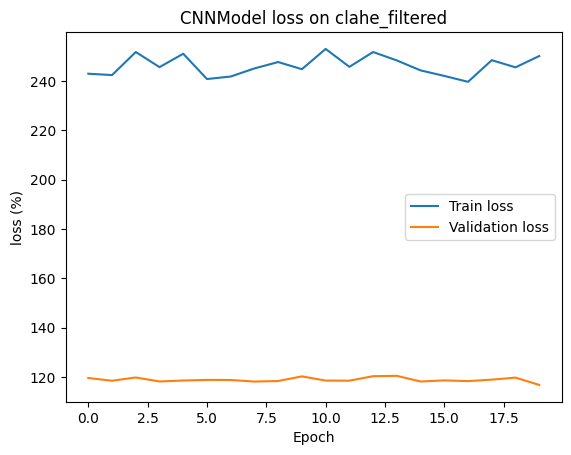

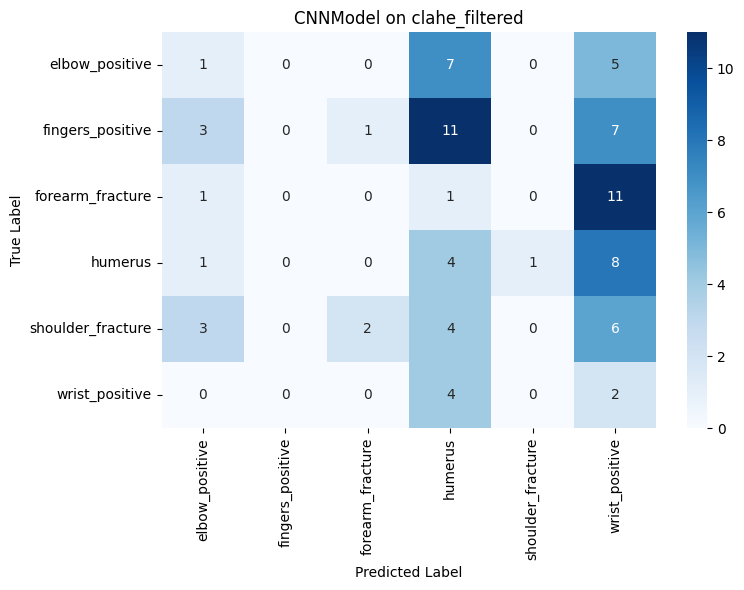

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
✅ Training model: VGG on clahe_filtered


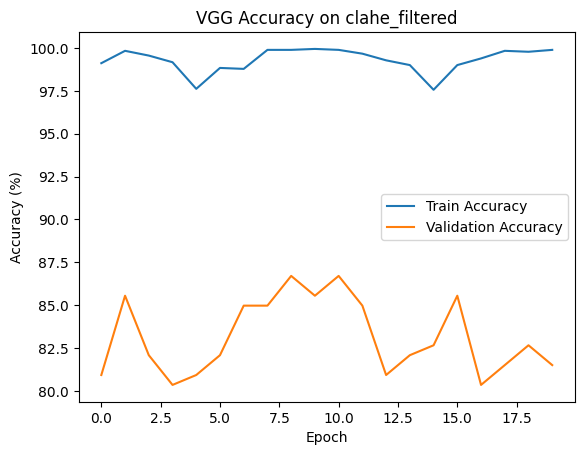

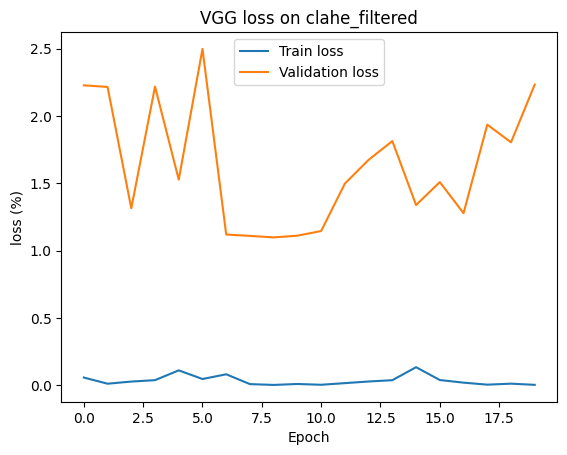

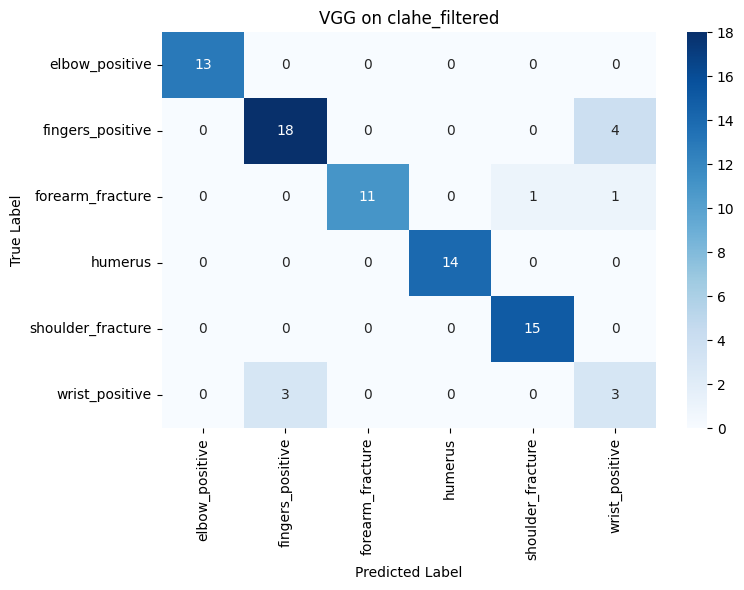

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
✅ Training model: ResNet on clahe_filtered


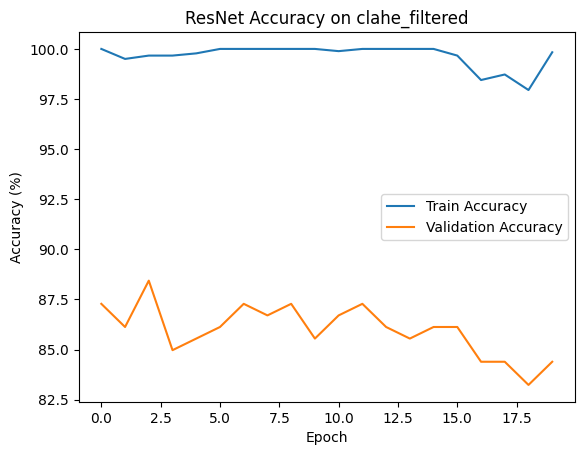

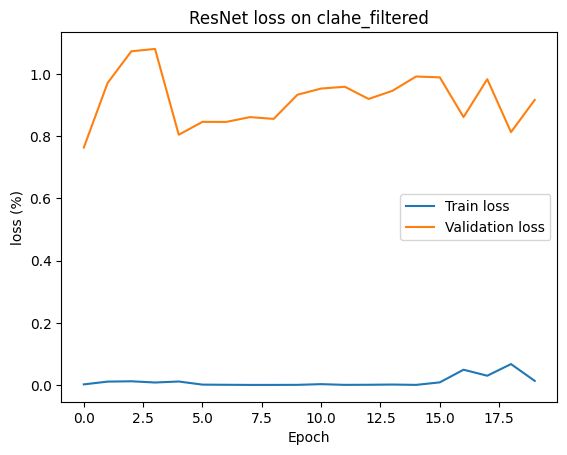

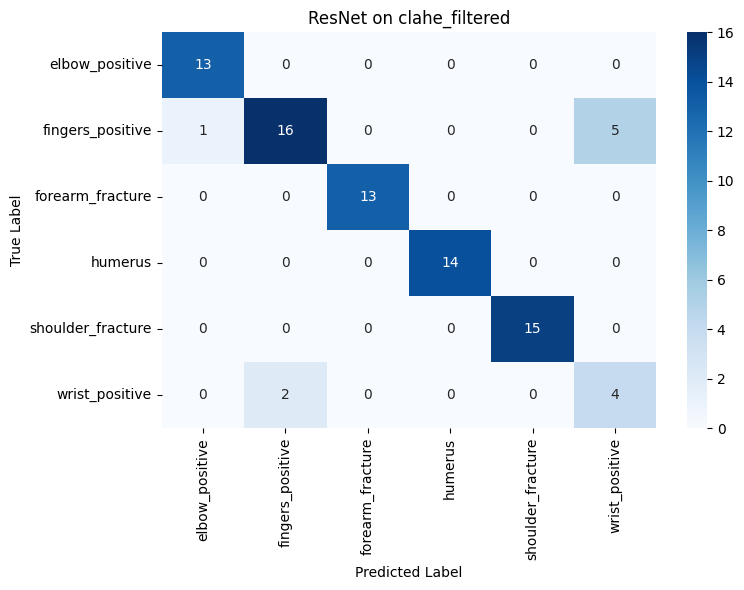

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
✅ Training model: DenseNet on clahe_filtered


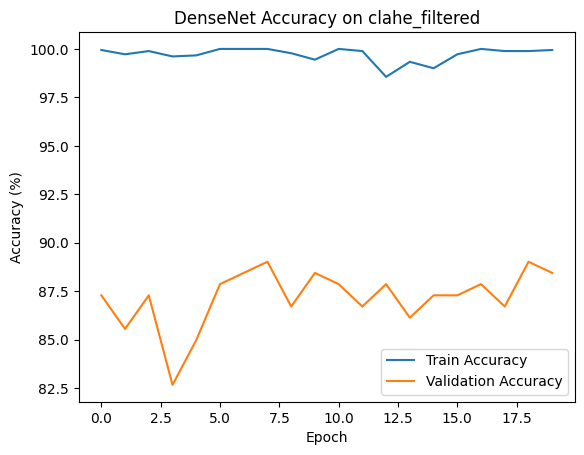

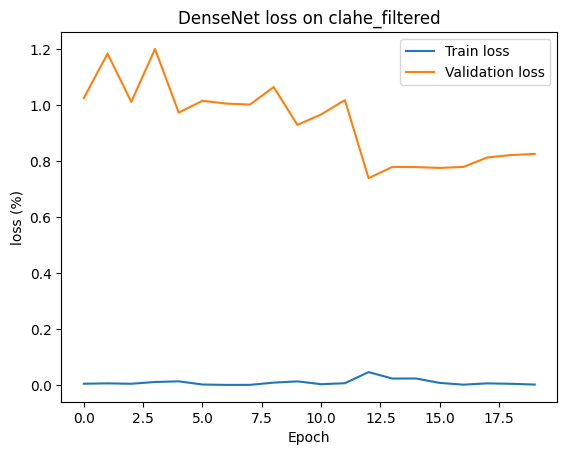

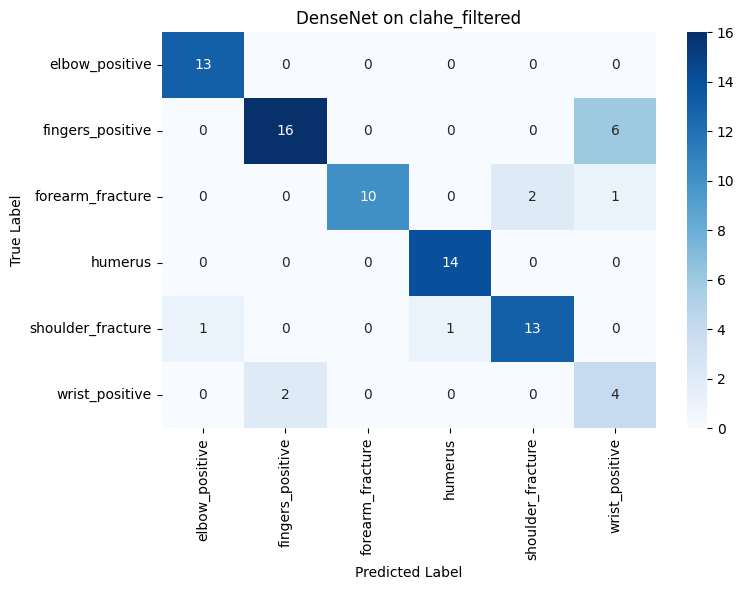

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
✅ Training model: EfficientNet on clahe_filtered


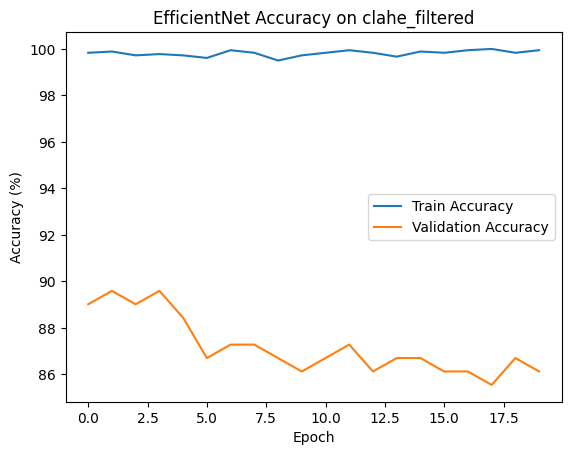

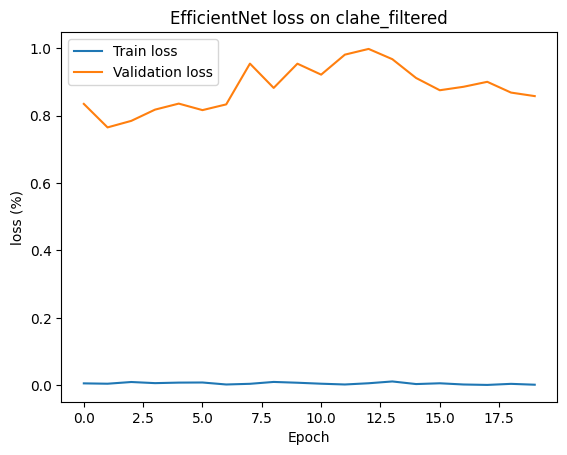

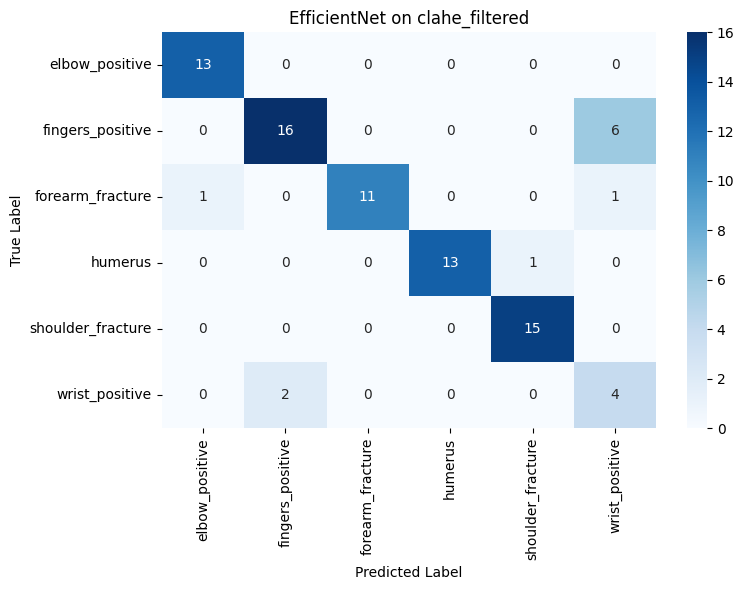

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
 Processing Filtered Dataset: bilateral_filtered
✅ Training model: CNNModel on bilateral_filtered
Epoch 1/20 : Train Loss: 232.8236, Train Acc: 14.7450 %;   Validation Loss: 120.3405, Validation Acc: 15.6069 %
Epoch 2/20 : Train Loss: 239.6750, Train Acc: 15.6874 %;   Validation Loss: 118.2125, Validation Acc: 14.4509 %
Epoch 3/20 : Train Loss: 227.5911, Train Acc: 16.1863 %;   Validation Loss: 119.6307, Validation Acc: 16.1850 %
Epoch 4/20 : Train Loss: 233.2862, Train Acc: 15.4102 %;   Validation Loss: 119.7428, Validation Acc: 15.6069 %
Epoch 5/20 : Train Loss: 234.7663, Train Acc: 14.6896 %;   Validation Loss: 118.4339, Validation Acc: 15.6069 %
Epoch 6/20 : Train Loss: 230.1492, Trai

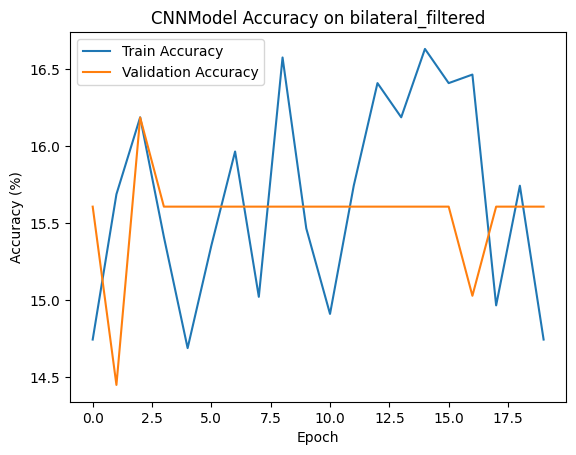

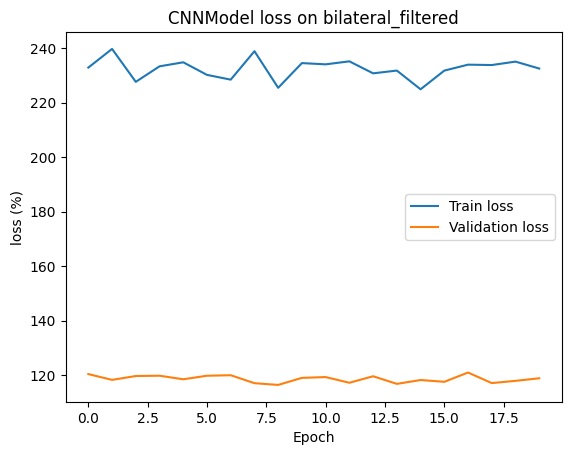

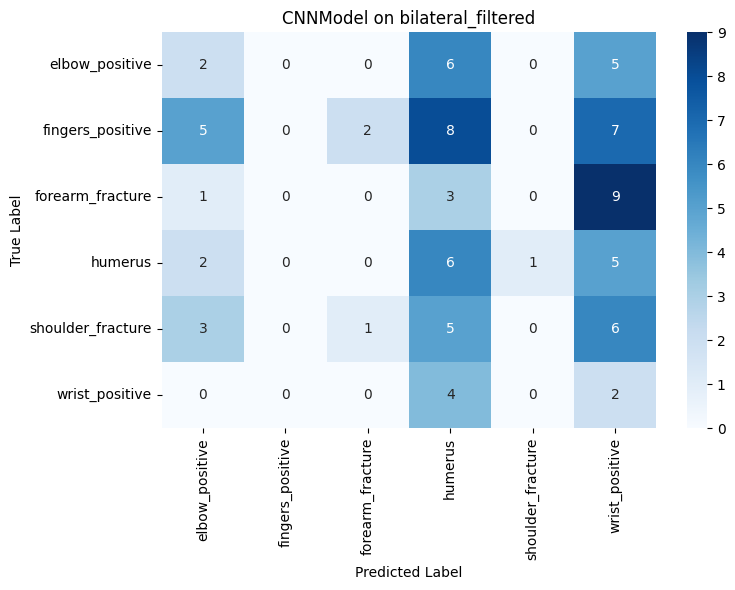

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
✅ Training model: VGG on bilateral_filtered


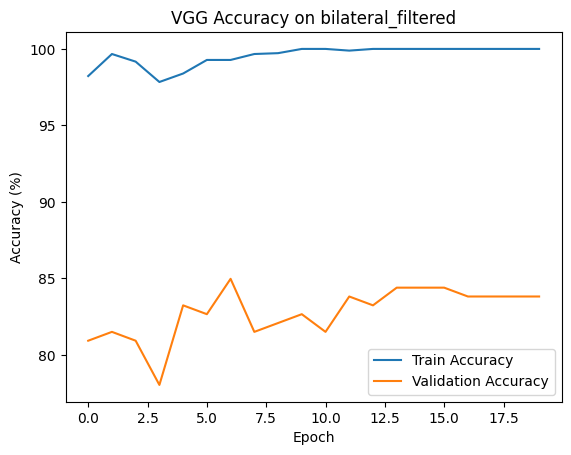

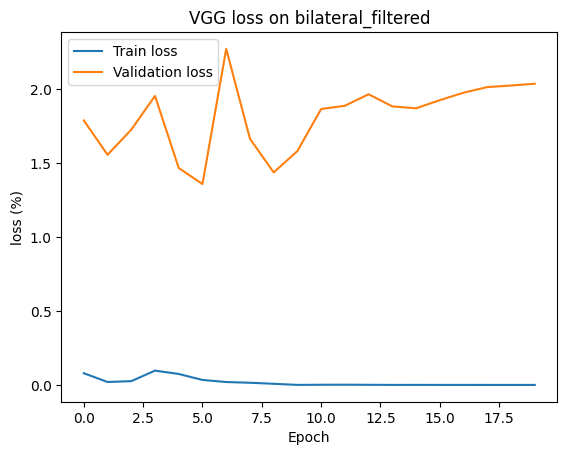

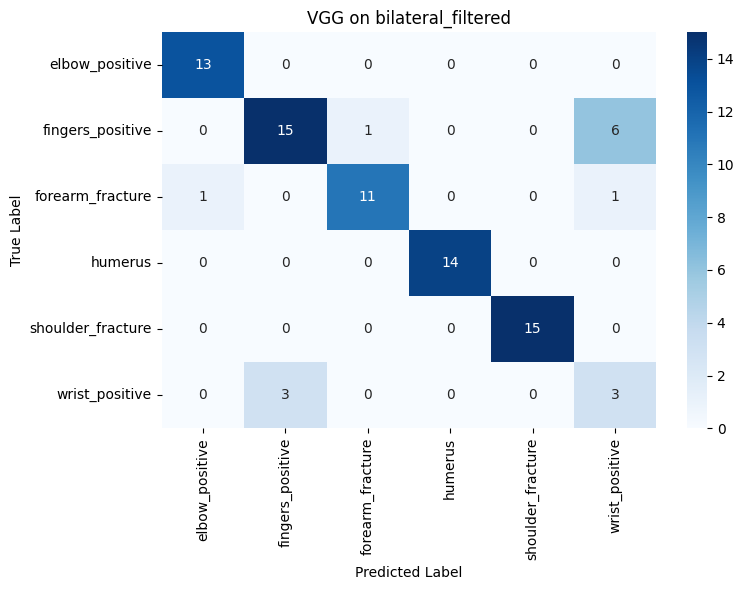

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
✅ Training model: ResNet on bilateral_filtered


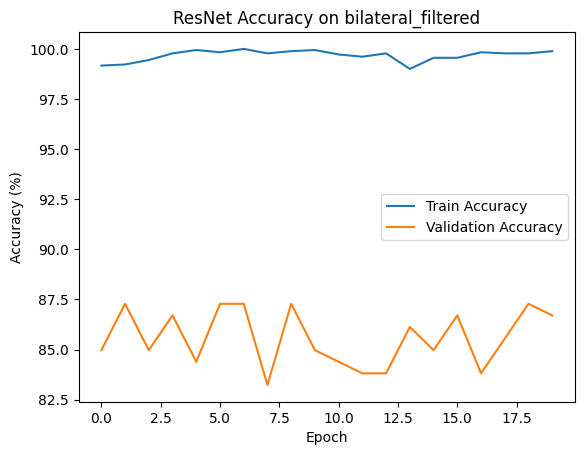

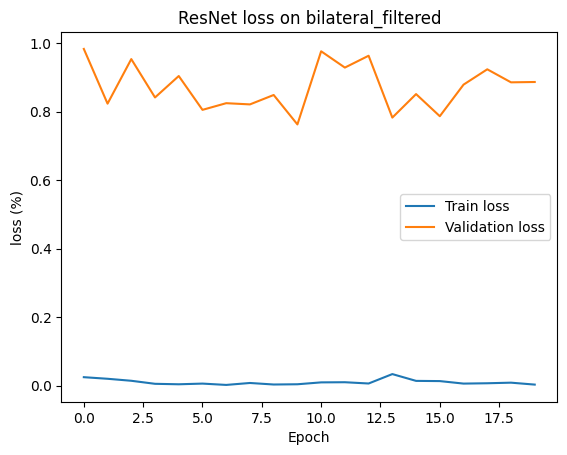

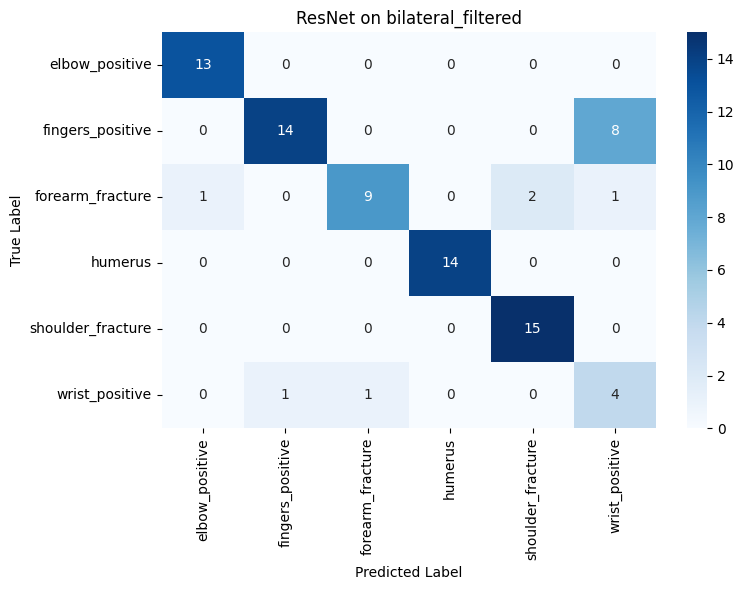

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
✅ Training model: DenseNet on bilateral_filtered


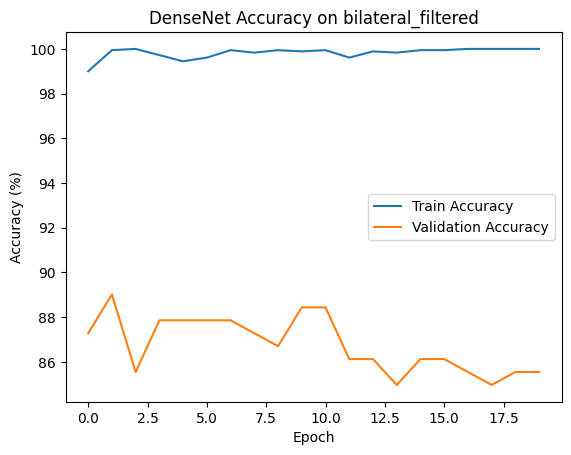

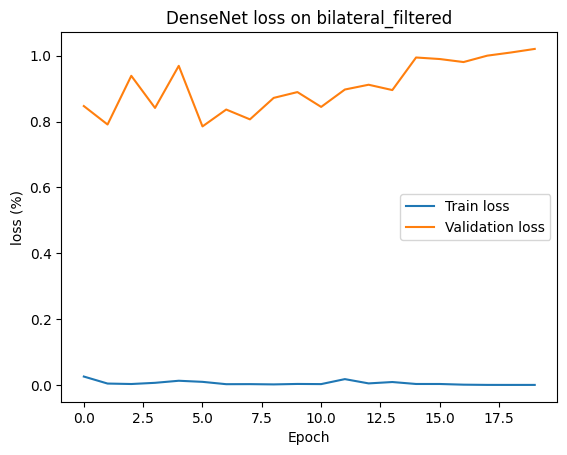

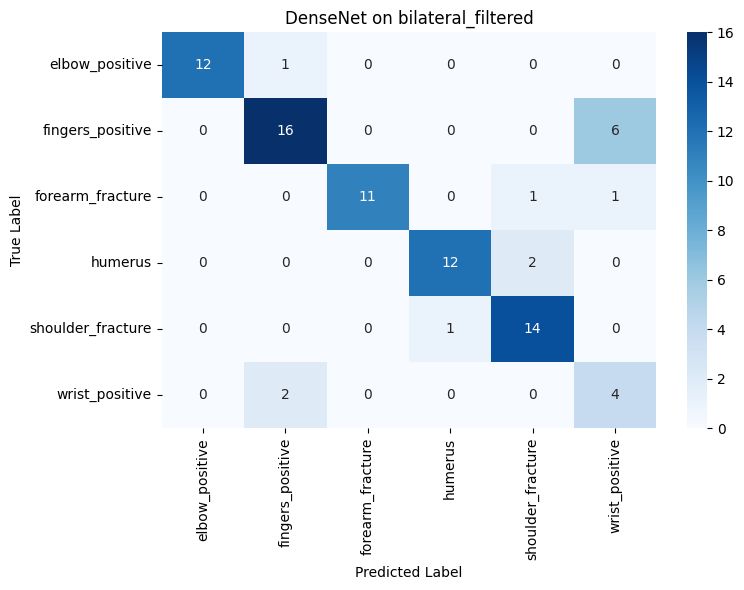

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
✅ Training model: EfficientNet on bilateral_filtered


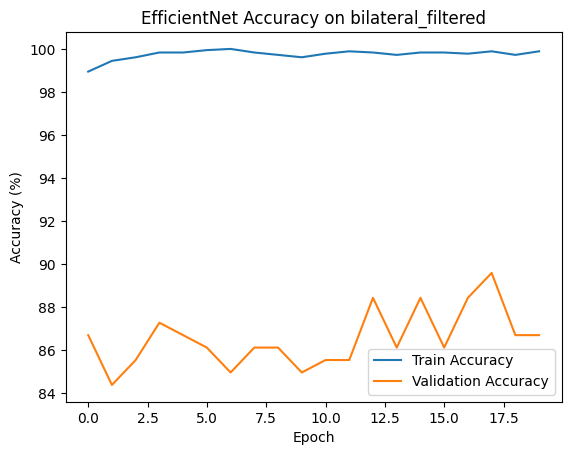

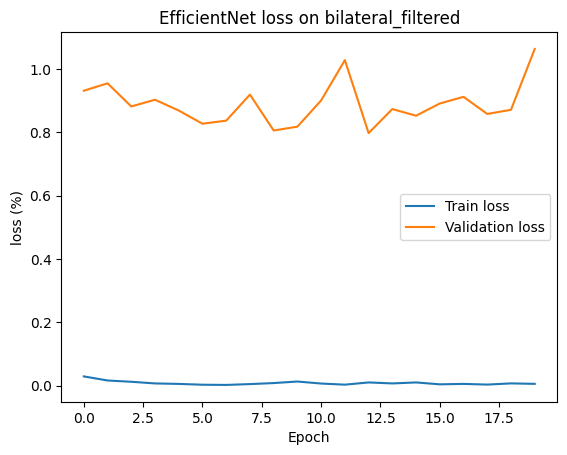

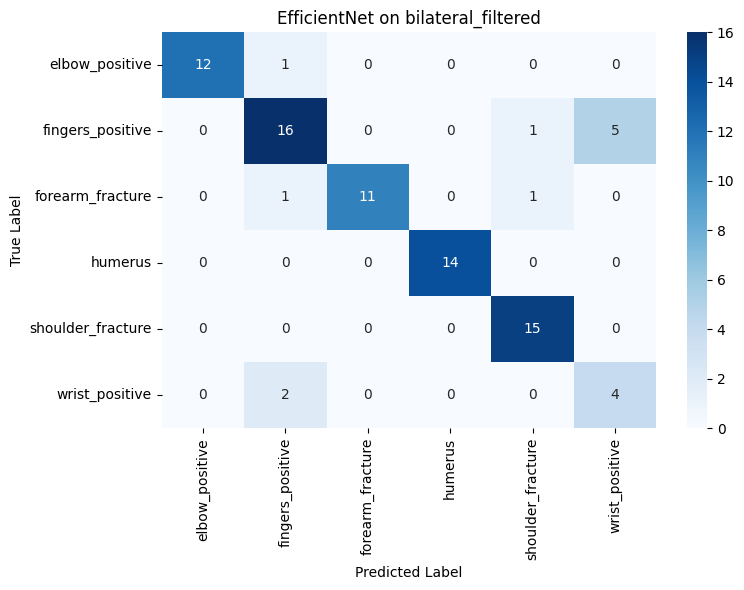

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


In [37]:
results = []

model_directory = '/kaggle/working/models'
os.makedirs(model_directory, exist_ok = True)

datasetDirs = ['bilateral_filtered', 'clahe_filtered', 'clahe_median_filtered', 'imageResize224*224', 'median_filtered']

for filt in os.listdir('/kaggle/working/'):
    if filt not in datasetDirs:
        continue
    os.makedirs(os.path.join(model_directory, filt), exist_ok = True)
    data_path = os.path.join('/kaggle/working/', filt)
    if not os.path.isdir(data_path): continue
    print(f" Processing Filtered Dataset: {filt}")

    # Load dataset
    train_dataset = datasets.ImageFolder(os.path.join(data_path, 'train'), transform=data_transforms['train'])
    valid_dataset = datasets.ImageFolder(os.path.join(data_path, 'valid'), transform=data_transforms['valid'])
    test_dataset  = datasets.ImageFolder(os.path.join(data_path, 'test'),  transform=data_transforms['test'])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    for model in pretrained_models:
        name = model.__class__.__name__
        print(f"✅ Training model: {name} on {filt}")

        os.makedirs(os.path.join(model_directory, filt, name), exist_ok = True)
        
        model_copy = model  # if you clone per model, else reset weights manually
        model_copy = model_copy.to(device)
        criterion = nn.CrossEntropyLoss()

        if isinstance(model, CNNModel):
            optimizer = torch.optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=SCHEDULER_STEP_SIZE, gamma=GAMMA)
            train_acc, val_acc, train_loss, val_loss = train_model_CNN(model_copy, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=20)
        else:
            optimizer = torch.optim.Adam(model_copy.parameters(), lr=1e-4)
            train_acc, val_acc, train_loss, val_loss = train_model(model_copy, train_loader, valid_loader, criterion, optimizer)

        # Plot Accuracy Curve
        plt.plot(train_acc, label='Train Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.title(f'{name} Accuracy on {filt}')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()
        plt.show()

        # Plot loss Curve
        plt.plot(train_loss, label='Train loss')
        plt.plot(val_loss, label='Validation loss')
        plt.title(f'{name} loss on {filt}')
        plt.xlabel("Epoch")
        plt.ylabel("loss (%)")
        plt.legend()
        plt.show()

        # Final test set evaluation
        acc, prec, rec, f1, y_true, y_pred = evaluate_model(model_copy, test_loader)
        results.append([name, filt, acc, prec, rec, f1])

        # Confusion matrix
        class_names = train_dataset.classes  # assumes same classes across splits
        plot_confusion_matrix(y_true, y_pred, class_names, title=f"{name} on {filt}")

        #os.makedirs(os.path.join(model_directory, filt, name), exist_ok=True)
        
        # ✅ Save model weights
        model_save_path = os.path.join(model_directory, filt, name, f"{filt}_weights.pth")
        torch.save(model_copy.state_dict(), model_save_path)

        print("----------------------------------------------------------------------------------------------------")
        print("----------------------------------------------------------------------------------------------------")
        print("----------------------------------------------------------------------------------------------------")


In [38]:
results_df = pd.DataFrame(results, columns=["Model", "Filter", "Accuracy", "Precision", "Recall", "F1-Score"])
print(results_df)

# Optional: Save to CSV
results_df.to_csv("/kaggle/working/benchmark_results.csv", index=False)

           Model                 Filter  Accuracy  Precision    Recall  \
0       CNNModel  clahe_median_filtered  0.096386   0.045350  0.096386   
1            VGG  clahe_median_filtered  0.867470   0.909328  0.867470   
2         ResNet  clahe_median_filtered  0.867470   0.911061  0.867470   
3       DenseNet  clahe_median_filtered  0.843373   0.888495  0.843373   
4   EfficientNet  clahe_median_filtered  0.879518   0.920624  0.879518   
5       CNNModel        median_filtered  0.108434   0.060330  0.108434   
6            VGG        median_filtered  0.867470   0.909328  0.867470   
7         ResNet        median_filtered  0.819277   0.863588  0.819277   
8       DenseNet        median_filtered  0.867470   0.909328  0.867470   
9   EfficientNet        median_filtered  0.819277   0.863690  0.819277   
10      CNNModel     imageResize224*224  0.108434   0.061364  0.108434   
11           VGG     imageResize224*224  0.843373   0.871386  0.843373   
12        ResNet     imageResize224*22